In [1]:
import os
import pandas as pd
from PIL import Image
import torch
import kagglehub
from pathlib import Path
from tqdm.auto import tqdm
import wandb

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### W&B setup

- We can manually set `USE_WANDB = False` to skip logging entirely.
- We need to paste wandb authentication key


In [2]:
# W&B login via built-in prompt (asks for key if not set)
USE_WANDB = True
if USE_WANDB:
    try:
        wandb.login(relogin=True, force=True)
        print("wandb: logged in via wandb.login prompt")
    except Exception as e:
        print(f"wandb login prompt failed ({e}); going offline")
        os.environ["WANDB_MODE"] = "offline"
        USE_WANDB = False
else:
    print("wandb disabled; skipping login prompt.")


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\matej\_netrc
wandb: Currently logged in as: xherzog (xherzog-fiit-stu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: logged in via wandb.login prompt


# Part 1 - EDA

In [3]:
# We choose available device on our machine
if hasattr(torch, "xpu") and torch.xpu.is_available():
    device = torch.device("xpu")
    os.environ["ALLOW_MULTIPROC_DATALOADER"] = "0"
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

if device.type == "cuda":
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
elif device.type == "xpu":
    try:
        print(f"XPU Name: {torch.xpu.get_device_name(0)}")
    except Exception:
        pass



Using device: xpu
XPU Name: Intel(R) Arc(TM) 140V GPU (16GB)


Set SEED for reproducibility

In [4]:
import random                    # Python's standard RNG
import numpy as np               # NumPy RNG for arrays

def set_seed(seed: int = 42):
    random.seed(seed)            # Seed Python's RNG
    np.random.seed(seed)         # Seed NumPy RNG
    torch.manual_seed(seed)      # Seed PyTorch CPU RNG
    torch.cuda.manual_seed_all(seed)  # Seed all CUDA devices
    torch.backends.cudnn.deterministic = True  # Deterministic cuDNN ops
    torch.backends.cudnn.benchmark = False     # Disable benchmark for determinism
    os.environ["PYTHONHASHSEED"] = str(seed)   # Seed hash-based ops

SEED = 42
set_seed(SEED)
print(f"Seeds set to {SEED}")

Seeds set to 42


Dataset Downloading

In [5]:
path = Path(kagglehub.dataset_download("alessiocorrado99/animals10")) / "raw-img"

print("Path to dataset files:", path)

Path to dataset files: C:\Users\matej\.cache\kagglehub\datasets\alessiocorrado99\animals10\versions\2\raw-img


Types Of Our Target Classes

In [6]:
clases = os.listdir(path)
print(clases)

['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


Print Number of Images per Class

In [7]:
print(f"{'Class Name':<20} | {'Count'}")
print("-" * 30)
for cl in clases:
    folder_path = path / cl
    count = len(os.listdir(folder_path))
    print(f"{cl:<20} | {count}")

Class Name           | Count
------------------------------
cane                 | 4863
cavallo              | 2623
elefante             | 1446
farfalla             | 2112
gallina              | 3098
gatto                | 1668
mucca                | 1866
pecora               | 1820
ragno                | 4821
scoiattolo           | 1862


## Downsampling Majority Classes and Visualizations
- We have found in our first experiments, that simply using the dataset as it was was not giving the best results.
- Our models were biased to majority classing and it looked like they guessed the minority ones.
- Simply put, downsampling helped us generalize our model and reduced it's bias to majority classes.

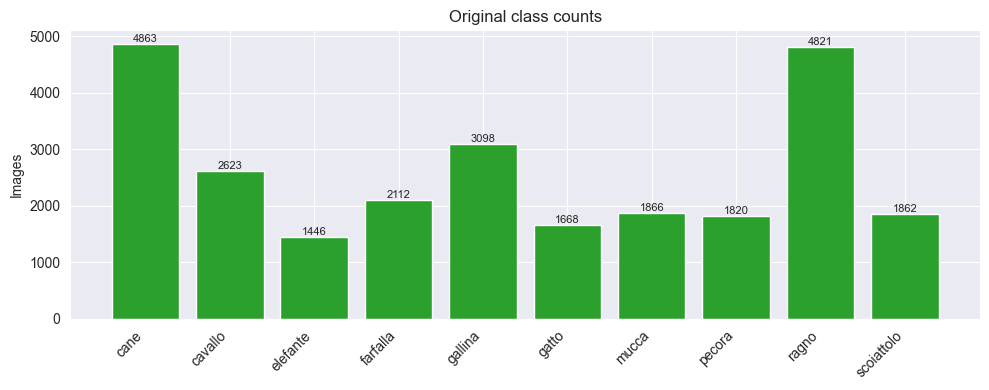

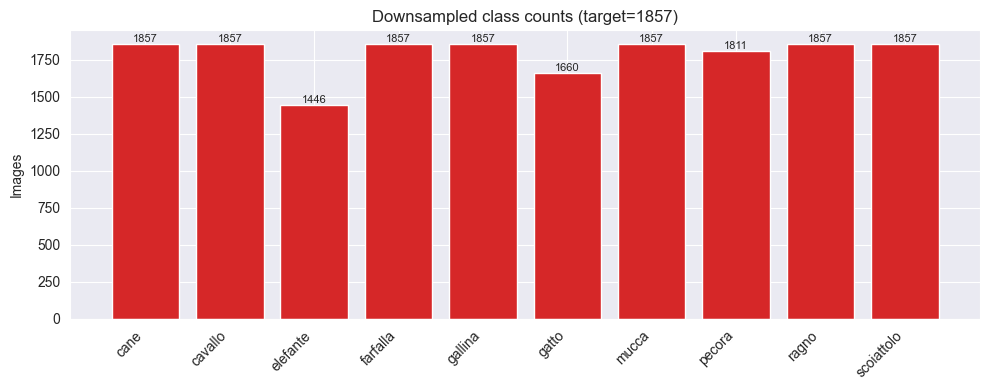

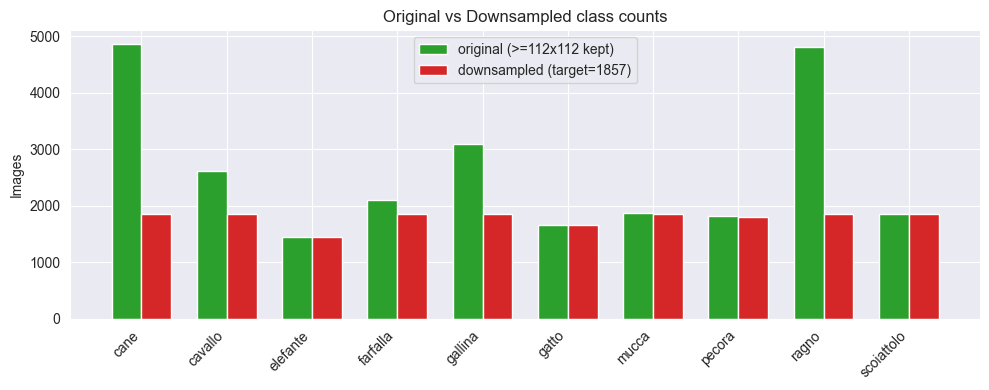

Dropped 58 images smaller than 112x112.
Using target count 1857 (4th lowest post-filter).
Total images after downsampling: 17916


In [8]:
import numpy as np

green_color = "#2ca02c"
red_color = "#d62728"
rng = random.Random(SEED)

# Collect per-class file lists
class_files = {}
for cl in clases:
    folder = path / cl
    if not folder.is_dir():
        continue
    class_files[cl] = [folder / f for f in os.listdir(folder)]

original_counts = {c: len(v) for c, v in class_files.items()}

# Filter out very small images
filtered_class_files = {}
dropped_small = 0
for cl, file_list in class_files.items():
    kept = []
    for fp in file_list:
        try:
            with Image.open(fp) as img:
                w, h = img.size
                if w < 112 or h < 112:
                    dropped_small += 1
                    continue
            kept.append(fp)
        except Exception:
            continue
    filtered_class_files[cl] = kept

filtered_counts = {c: len(v) for c, v in filtered_class_files.items()}

# Determine downsample target = 4th lowest count (post-filter)
sorted_counts = sorted(filtered_counts.values())
if len(sorted_counts) >= 4:
    target_count = sorted_counts[3]
else:
    target_count = min(sorted_counts) if sorted_counts else 0

balanced_class_files = {}
for cl, file_list in filtered_class_files.items():
    if len(file_list) > target_count:
        balanced_class_files[cl] = rng.sample(file_list, target_count)
    else:
        balanced_class_files[cl] = list(file_list)

downsampled_counts = {c: len(v) for c, v in balanced_class_files.items()}

# Plotting Tools
def plot_counts(counts, title, color):
    classes = sorted(counts.keys())
    values = [counts[c] for c in classes]
    plt.figure(figsize=(10, 4))
    bars = plt.bar(classes, values, color=color)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Images")
    plt.title(title)
    for b, val in zip(bars, values):
        plt.text(b.get_x() + b.get_width() / 2, b.get_height(), str(val), ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()

plot_counts(original_counts, "Original class counts", green_color)
plot_counts(downsampled_counts, f"Downsampled class counts (target={target_count})", red_color)

# Combined comparison plot
classes_sorted = sorted(original_counts.keys())
x = np.arange(len(classes_sorted))
orig_vals = [original_counts.get(c, 0) for c in classes_sorted]
down_vals = [downsampled_counts.get(c, 0) for c in classes_sorted]
width = 0.35
plt.figure(figsize=(10, 4))
plt.bar(x - width / 2, orig_vals, width, color=green_color, label="original (>=112x112 kept)")
plt.bar(x + width / 2, down_vals, width, color=red_color, label=f"downsampled (target={target_count})")
plt.xticks(x, classes_sorted, rotation=45, ha='right')
plt.ylabel("Images")
plt.title("Original vs Downsampled class counts")
plt.legend()
plt.tight_layout()
plt.show()

# Build balanced file/label lists for downstream splits
class_names = sorted(balanced_class_files.keys())
class_to_idx = {c: i for i, c in enumerate(class_names)}
files = []
labels = []
for cl in class_names:
    for fp in balanced_class_files[cl]:
        files.append(str(fp))
        labels.append(class_to_idx[cl])

print(f"Dropped {dropped_small} images smaller than 112x112.")
print(f"Using target count {target_count} (4th lowest post-filter).")
print(f"Total images after downsampling: {len(files)}")

## Visualize Our images
- We have 10 image classes
- Let's visualize a few of them:

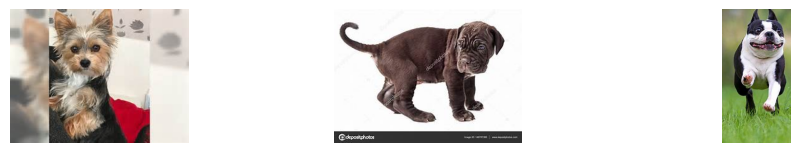

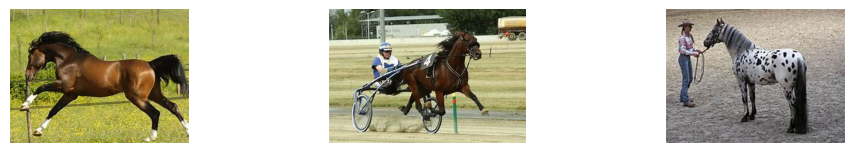

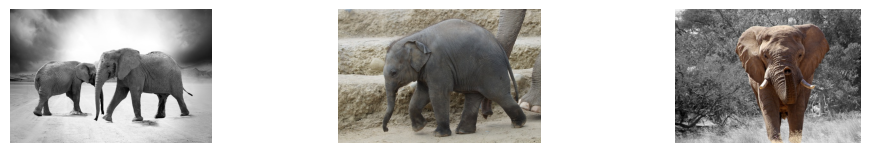

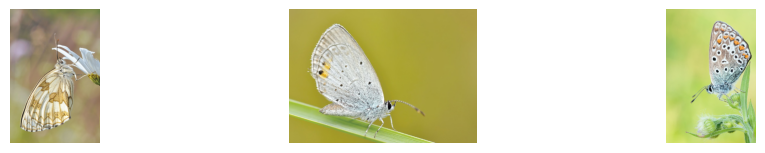

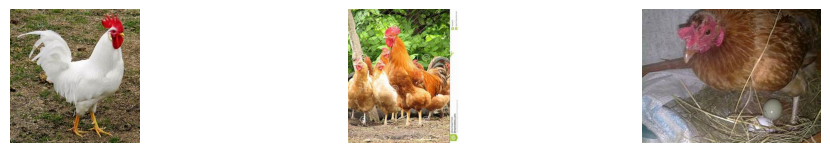

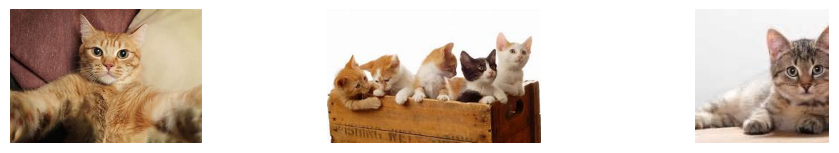

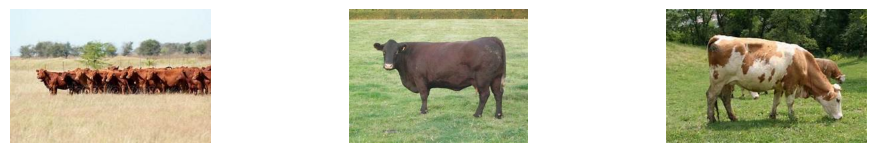

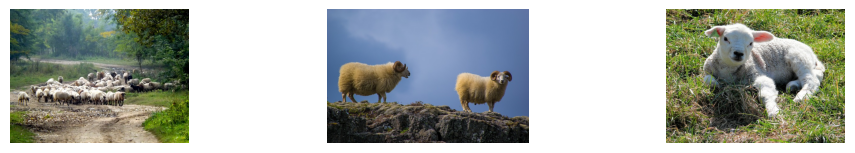

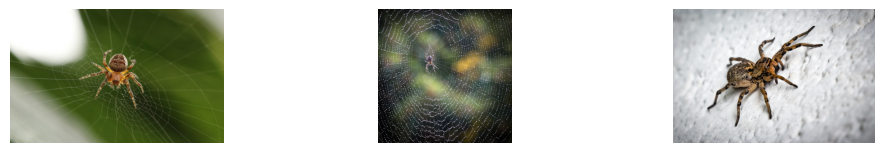

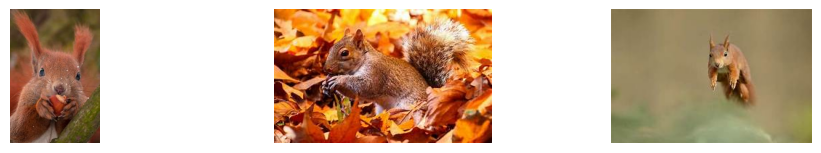

In [9]:
for cl in clases:
    n=3
    plt.figure(figsize=(12, 8))
    a = path / cl
    imgs = os.listdir(a)
    i=1
    for _ in range(n):
        img_path = a / imgs[_]
        img = Image.open(img_path)

        plt.subplot(4, n, i)
        plt.imshow(img)
        plt.axis("off")
        i += 1

## Analysis Of The Image Sizes
- We have seen, that our images appear to be of different sizes.
- We will calculate some statistics regarding image sizes.
- Some images seem to be to small, our pipeline converts images to 224x224 pixels.
- As we decided in the downsampling phase, we dropped images whose dimensions were lower than of a picture of size 112x112.
- Less than half of what our network wants.

In [10]:
print(f"{'Class':<20} | {'Min W':<6} | {'Max W':<6} | {'Avg W':<8} | {'Min H':<6} | {'Max H':<6} | {'Avg H':<8}")
print("-" * 80)

# Ensure unique classes and sort them
unique_clases = sorted(list(set(clases)))

for cl in unique_clases:
    folder_path = path / cl
    widths = []
    heights = []

    # Skip if not a directory
    if not folder_path.is_dir():
        continue

    # Get all images in the class folder
    try:
        imgs = os.listdir(folder_path)
    except Exception:
        continue

    for im_name in imgs:
        img_path = folder_path / im_name
        try:
            with Image.open(img_path) as im:
                w, h = im.size
                widths.append(w)
                heights.append(h)
        except Exception as e:
            # print(f"Error reading {img_path}: {e}")
            continue

    if widths and heights:
        min_w = min(widths)
        max_w = max(widths)
        avg_w = sum(widths) / len(widths)

        min_h = min(heights)
        max_h = max(heights)
        avg_h = sum(heights) / len(heights)

        print(f"{cl:<20} | {min_w:<6} | {max_w:<6} | {avg_w:<8.1f} | {min_h:<6} | {max_h:<6} | {avg_h:<8.1f}")
    else:
        print(f"{cl:<20} | No images found or error reading images")

Class                | Min W  | Max W  | Avg W    | Min H  | Max H  | Avg H   
--------------------------------------------------------------------------------
cane                 | 109    | 300    | 283.6    | 101    | 300    | 241.1   
cavallo              | 60     | 300    | 287.9    | 57     | 300    | 233.5   
elefante             | 189    | 640    | 377.6    | 115    | 640    | 274.9   
farfalla             | 65     | 640    | 364.5    | 64     | 640    | 280.4   
gallina              | 82     | 300    | 288.3    | 95     | 300    | 239.4   
gatto                | 107    | 6720   | 473.2    | 75     | 6000   | 364.6   
mucca                | 120    | 300    | 294.2    | 86     | 300    | 212.7   
pecora               | 107    | 640    | 363.0    | 71     | 640    | 263.4   
ragno                | 88     | 640    | 311.1    | 80     | 640    | 247.8   
scoiattolo           | 127    | 300    | 287.8    | 97     | 300    | 224.6   


## Analysis Of Image Channels
- Let's see if we have RGB images channelwise.
- We can see that almost all have RGB channels
- We have negligable amounts of the other image channel sizes.

In [11]:
# Analyze Image Channels
modes = {}
channels_count = {}

print("Analyzing image modes and channels")
for cl in clases:
    folder = path / cl
    for img_name in os.listdir(folder):
        img_path = folder / img_name
        try:
            with Image.open(img_path) as img:
                # Count modes (RGB, L, CMYK, etc.)
                modes[img.mode] = modes.get(img.mode, 0) + 1
                # Count channels
                c = len(img.getbands())
                channels_count[c] = channels_count.get(c, 0) + 1
        except:
            pass

print("Image Modes:", modes)
print("Channel Counts:", channels_count)

if 1 in channels_count or 4 in channels_count:
    print("\nNote: Dataset contains images with different channel counts.")
    print("We will convert all images to RGB (3 channels/parameters per pixel) during preprocessing.")
else:
    print("\nAll images are already 3 channels (RGB).")

Analyzing image modes and channels
Image Modes: {'RGB': 26128, 'RGBA': 49, 'L': 1, 'CMYK': 1}
Channel Counts: {3: 26128, 4: 50, 1: 1}

Note: Dataset contains images with different channel counts.
We will convert all images to RGB (3 channels/parameters per pixel) during preprocessing.


## Analyze if RGB images are truly Colorful
- Now we chceck wheter the channels themselves are similar or not.
- Channel similarity suggests that we might have grayscale like images but in RGB format.
- Our results show, that most images are RGB-like.
- The amount of grayscale-like is negligible

In [12]:
# Analyze color distribution in images
# Check if RGB images are truly colorful or essentially grayscale

import numpy as np

def analyze_color_info(img):
    """
    Analyze if an image is truly colorful or grayscale-like.
    Returns metrics about color saturation and channel differences.
    """
    img_array = np.array(img.convert("RGB"))

    # Calculate channel-wise statistics
    r, g, b = img_array[:,:,0], img_array[:,:,1], img_array[:,:,2]

    # Check if channels are similar (grayscale-like)
    # If R ≈ G ≈ B for all pixels, image is grayscale
    rg_diff = np.abs(r.astype(float) - g.astype(float)).mean()
    rb_diff = np.abs(r.astype(float) - b.astype(float)).mean()
    gb_diff = np.abs(g.astype(float) - b.astype(float)).mean()

    avg_channel_diff = (rg_diff + rb_diff + gb_diff) / 3

    # Calculate color saturation using HSV-like approach
    max_channel = np.maximum(np.maximum(r, g), b).astype(float)
    min_channel = np.minimum(np.minimum(r, g), b).astype(float)

    # Saturation: difference between max and min channel
    saturation = np.where(max_channel > 0, (max_channel - min_channel) / max_channel, 0)
    avg_saturation = saturation.mean()

    return avg_channel_diff, avg_saturation

print("Analyzing color characteristics per class...")
print(f"{'Class':<20} | {'Colorful':<10} | {'Grayscale-like':<15} | {'Avg Channel Diff':<18} | {'Avg Saturation':<15}")
print("-" * 90)

unique_clases = sorted(list(set(clases)))

for cl in unique_clases:
    folder_path = path / cl

    if not folder_path.is_dir():
        continue

    colorful_count = 0
    grayscale_like_count = 0
    total_channel_diff = 0
    total_saturation = 0
    valid_images = 0

    imgs = os.listdir(folder_path)

    for im_name in imgs:
        img_path = folder_path / im_name
        try:
            with Image.open(img_path) as im:
                channel_diff, saturation = analyze_color_info(im)
                total_channel_diff += channel_diff
                total_saturation += saturation
                valid_images += 1

                # Threshold: if avg channel difference < 5, consider grayscale-like
                if channel_diff < 5:
                    grayscale_like_count += 1
                else:
                    colorful_count += 1
        except Exception:
            continue

    if valid_images > 0:
        avg_diff = total_channel_diff / valid_images
        avg_sat = total_saturation / valid_images
        print(f"{cl:<20} | {colorful_count:<10} | {grayscale_like_count:<15} | {avg_diff:<18.2f} | {avg_sat:<15.4f}")

print("\nNote: Grayscale-like = RGB images where R ≈ G ≈ B (avg channel diff < 5)")
print("Saturation: 0 = no color, 1 = fully saturated")

Analyzing color characteristics per class...
Class                | Colorful   | Grayscale-like  | Avg Channel Diff   | Avg Saturation 
------------------------------------------------------------------------------------------


C:\Users\matej\AppData\Local\Temp\ipykernel_13388\3893971965.py:29: RuntimeWarning: invalid value encountered in divide
  saturation = np.where(max_channel > 0, (max_channel - min_channel) / max_channel, 0)


cane                 | 4663       | 200             | 24.83              | 0.3060         
cavallo              | 2566       | 57              | 25.28              | 0.3236         
elefante             | 1381       | 65              | 23.85              | 0.2933         
farfalla             | 2083       | 29              | 37.49              | 0.4510         
gallina              | 3050       | 48              | 24.45              | 0.3087         
gatto                | 1514       | 154             | 21.09              | 0.2663         
mucca                | 1841       | 25              | 28.81              | 0.3628         
pecora               | 1790       | 30              | 27.52              | 0.3494         
ragno                | 4517       | 304             | 28.29              | 0.3336         
scoiattolo           | 1842       | 20              | 25.94              | 0.3393         

Note: Grayscale-like = RGB images where R ≈ G ≈ B (avg channel diff < 5)
Saturation: 0 = 

## Data Splitting
- TRAIN: 70%
- VALIDATION: 15%
- TEST: 15%

In [13]:
# Use balanced, size-filtered, downsampled dataset prepared earlier
print("Loading preprocessed balanced dataset (size-filtered and downsampled).")
print(f"Total images loaded: {len(files)}")
print(f"Total classes: {len(class_names)}")
print(f"Class mapping: {class_to_idx}")

Loading preprocessed balanced dataset (size-filtered and downsampled).
Total images loaded: 17916
Total classes: 10
Class mapping: {'cane': 0, 'cavallo': 1, 'elefante': 2, 'farfalla': 3, 'gallina': 4, 'gatto': 5, 'mucca': 6, 'pecora': 7, 'ragno': 8, 'scoiattolo': 9}


In [14]:
print("Splitting dataset into Train / Val / Test sets...")
train_files, temp_files, train_labels, temp_labels = train_test_split(
    files, labels,
    test_size=0.30,
    stratify=labels,
    shuffle=True,
    random_state=42
 )

# Split remaining 30% into validation and test (15% / 15%)
val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels,
    test_size=0.50,
    stratify=temp_labels,
    shuffle=True,
    random_state=42
 )

print(f"Training samples: {len(train_files)}")
print(f"Validation samples: {len(val_files)}")
print(f"Testing samples: {len(test_files)}")

Splitting dataset into Train / Val / Test sets...
Training samples: 12541
Validation samples: 2687
Testing samples: 2688


## Calculation of MEAN and STD for Normalization
We calculate the mean and std per channel in our training data split to prevent data leakage. We fit our preprocessing techniques only on training data.

In [16]:
import torch

from torchvision import datasets, transforms

from torch.utils.data import DataLoader

IS_COLAB = "COLAB_GPU" in os.environ

MAX_WORKERS = os.cpu_count() or 2

ALLOW_MULTIPROC = os.environ.get("ALLOW_MULTIPROC_DATALOADER", "0") == "1"

# Colab warns above 2 workers; keep it small there. Otherwise allow up to 4 on GPU.
if IS_COLAB:
    NUM_WORKERS = 2
elif device.type in ("cuda", "xpu"):
    NUM_WORKERS = min(4, MAX_WORKERS)
else:
    NUM_WORKERS = 0

# Notebook-safe default: force single-process loading to avoid worker shutdown AssertionError.
if not ALLOW_MULTIPROC:
    NUM_WORKERS = 0

PIN_MEMORY = device.type == "cuda" and NUM_WORKERS > 0

print(f"DataLoader workers: {NUM_WORKERS}, pin_memory={PIN_MEMORY}")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(path, transform=transform)

loader = DataLoader(
    dataset,
    batch_size=64,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

sum_ = torch.zeros(3, dtype=torch.double)
sum_sq = torch.zeros(3, dtype=torch.double)
total_pixels = 0

for images, _ in loader:
    b, c, h, w = images.shape
    num_pixels_in_batch = b * h * w
    sum_ += images.sum(dim=[0, 2, 3]).double()
    sum_sq += (images ** 2).sum(dim=[0, 2, 3]).double()
    total_pixels += num_pixels_in_batch

mean_calculated = sum_ / total_pixels
var = (sum_sq / total_pixels) - (mean_calculated ** 2)
std_calculated = torch.sqrt(var)

print("Mean:", mean_calculated.tolist())
print("Std: ", std_calculated.tolist())

DataLoader workers: 0, pin_memory=False
Mean: [0.5177037193957041, 0.5002956887405993, 0.41255208682321987]
Std:  [0.2659483343247254, 0.26099434302033075, 0.2785206766283863]


## Define Our Image Transformations and Augmentations
- Conversion to RGB
- Resizing to 224x224
- Horizontal Flipping (probability = 50%)
- Brightness and Contrast Jittering
- Normalization

In [18]:
# Define training transformations with augmentation
train_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")), # Ensure 3 channels (R, G, B)
    transforms.Resize((224, 224)),                 # Resize to consistent size
    transforms.RandomHorizontalFlip(p=0.5),        # Data Augmentation: Flip
    #transforms.RandomRotation(5),                  # Data Augmentation: Rotate
    transforms.ColorJitter(                        # Data Augmentation: Color
        brightness=0.15,
        contrast=0.15
    ),
    transforms.ToTensor(),                         # Convert to Tensor (0-1 range)
    transforms.Normalize(                          # Normalize to range [-1, 1]
        # mean = [0.517707626799793, 0.5003007536238897, 0.4125557296095215],
        # std = [0.26413124327703913, 0.25914410756442957, 0.27683583555842795]
        mean = mean_calculated.tolist(),
        std = std_calculated.tolist()

    )
])
print("Training transforms defined.")

Training transforms defined.


Visual Check if our Augmentations Work

Visualizing Training Augmentations:


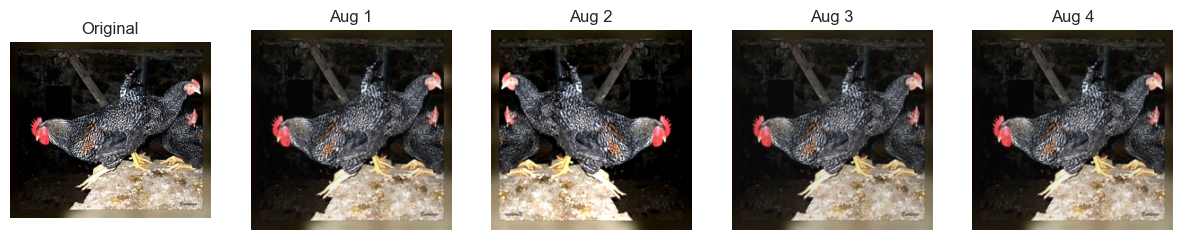

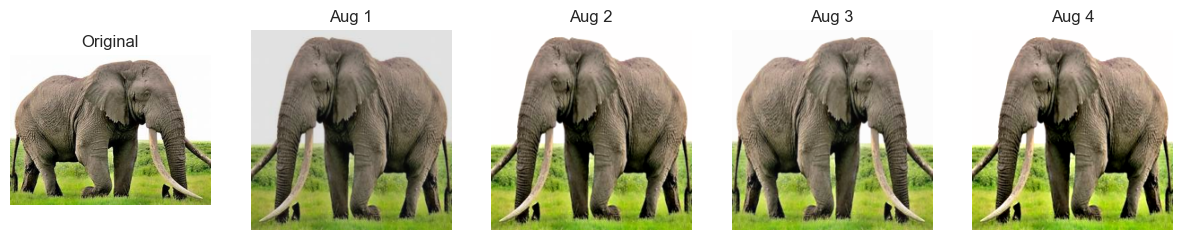

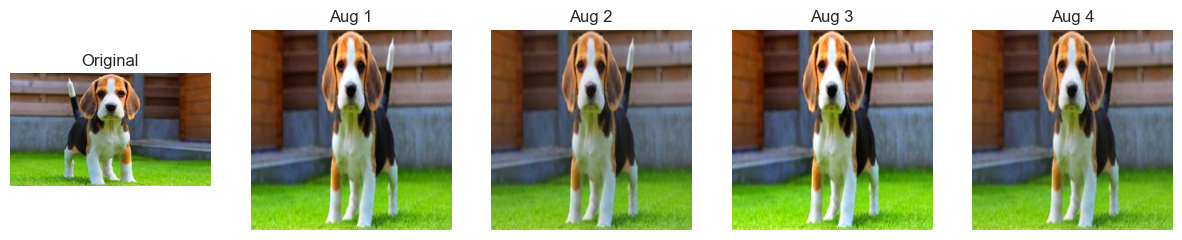

In [21]:
# Visualization of Augmentations
import numpy as np
import random

def visualize_augmentations(files, transform, n_samples=3):
    """
    Visualizes original images and their augmented versions.
    """
    # Select random files
    sample_files = random.sample(files, n_samples)

    for img_path in sample_files:
        # Load original
        original_img = Image.open(img_path)

        # Apply transform multiple times to see variations
        fig, axes = plt.subplots(1, 5, figsize=(15, 3))

        # Show original
        axes[0].imshow(original_img)
        axes[0].set_title("Original")
        axes[0].axis('off')

        mean = np.array(mean_calculated.tolist())
        std = np.array(std_calculated.tolist())

        for i in range(1, 5):
            # Apply transform
            aug_tensor = transform(original_img)

            # Un-normalize and convert to numpy for display
            aug_img = aug_tensor.permute(1, 2, 0).numpy()
            aug_img = (aug_img * std) + mean
            aug_img = np.clip(aug_img, 0, 1)

            axes[i].imshow(aug_img)
            axes[i].set_title(f"Aug {i}")
            axes[i].axis('off')
        plt.show()

print("Visualizing Training Augmentations:")
visualize_augmentations(train_files, train_transform)


In [22]:
# Define test transformations (no augmentation)
test_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")), # Ensure 3 channels
    transforms.Resize((224, 224)),                 # Resize to consistent size
    transforms.ToTensor(),                         # Convert to Tensor
    transforms.Normalize(                          # Normalize to range [-1, 1]
        mean_calculated,
        std_calculated
    )
])
print("Test transforms defined.")

Test transforms defined.


## Creation Of Our Datasets

In [23]:
class AnimalDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, self.labels[idx]

# Initialize Datasets
print("Initializing Datasets...")
train_dataset = AnimalDataset(train_files, train_labels, transform=train_transform)
val_dataset = AnimalDataset(val_files, val_labels, transform=test_transform)
test_dataset = AnimalDataset(test_files, test_labels, transform=test_transform)

# Initialize DataLoaders
BATCH_SIZE = 64
print(f"Initializing DataLoaders with batch size {BATCH_SIZE} and {NUM_WORKERS} workers...")
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

print("Data preparation complete.")


Initializing Datasets...
Initializing DataLoaders with batch size 64 and 0 workers...
Data preparation complete.


**Check If Datasets Work**

We Denormalize the data and then visualize it.

Visualizing samples from Test Dataset (Preprocessed)...


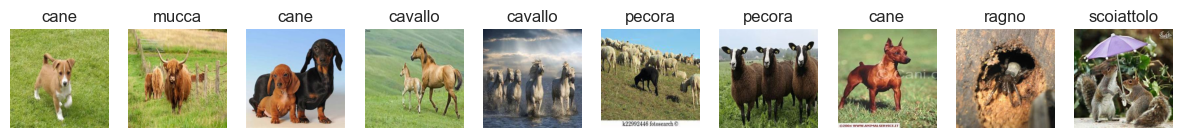

In [24]:
# Visualize Test Data
print("Visualizing samples from Test Dataset (Preprocessed)...")

def visualize_dataset_samples(dataset, class_names, n_samples=5):
    indices = random.sample(range(len(dataset)), n_samples)

    fig, axes = plt.subplots(1, n_samples, figsize=(15, 3))

    mean = np.array(mean_calculated.tolist())
    std = np.array(std_calculated.tolist())

    for i, idx in enumerate(indices):
        image, label = dataset[idx]

        # Denormalize for visualization
        img_display = image.permute(1, 2, 0).numpy()
        img_display = (img_display * std) + mean
        img_display = np.clip(img_display, 0, 1)

        axes[i].imshow(img_display)
        axes[i].set_title(class_names[label])
        axes[i].axis('off')

    plt.show()

visualize_dataset_samples(test_dataset, class_names, 10)


# Part 2 - Model Architecture and Experiments

## CNN Model Architecture

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, cfg):
        super().__init__()

        k = cfg.get("kernel", 3)
        s = cfg.get("stride", 1)
        p = cfg.get("padding", 1)

        use_bn = cfg.get("use_batchnorm", False)
        use_do = cfg.get("use_dropout", False)
        dr = cfg.get("dropout_rate", 0.3)
        bottleneck = cfg.get("use_bottleneck", False)

        layers = []

        if bottleneck:
            mid = out_ch // 4

            layers += [
                nn.Conv2d(in_ch, mid, kernel_size=1),
                nn.BatchNorm2d(mid) if use_bn else nn.Identity(),
                nn.ReLU(),
                nn.Conv2d(mid, mid, kernel_size=k, stride=s, padding=p),
                nn.BatchNorm2d(mid) if use_bn else nn.Identity(),
                nn.ReLU(),
                nn.Conv2d(mid, out_ch, kernel_size=1),
                nn.BatchNorm2d(out_ch) if use_bn else nn.Identity(),
            ]
        else:
            layers += [
                nn.Conv2d(in_ch, out_ch, kernel_size=k, stride=s, padding=p),
                nn.BatchNorm2d(out_ch) if use_bn else nn.Identity(),
                nn.ReLU(),
            ]

        if use_do:
            layers += [nn.Dropout2d(dr)]

        self.block = nn.Sequential(*layers)

        needs_proj = (in_ch != out_ch) or (s != 1)
        self.proj = (
            nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=s)
            if needs_proj
            else nn.Identity()
        )
        self.use_skip = cfg.get("use_skip_connections", False)

    def forward(self, x):
        out = self.block(x)
        if self.use_skip:
            out += self.proj(x)
        return F.relu(out)


class CustomCNN(nn.Module):
    def __init__(self, cfg: dict):
        super().__init__()

        model_cfg = cfg["model"]
        conv_cfgs = model_cfg["conv_blocks"]

        use_bn = model_cfg.get("use_batchnorm", False)
        use_do = model_cfg.get("use_dropout", False)
        dr = model_cfg.get("dropout_rate", 0.3)
        use_skip = model_cfg.get("use_skip_connections", False)
        use_bottleneck = model_cfg.get("use_bottleneck", False)

        fc_layers = model_cfg["fc_layers"]
        num_classes = cfg["data"]["num_classes"]

        conv_layers = []
        in_ch = 3

        # Calculate output spatial dimensions after conv blocks
        input_h, input_w = cfg["data"]["input_size"]
        current_h, current_w = input_h, input_w
        num_pools = 0

        for block in conv_cfgs:
            pool_after = block.get("pool", False)
            block_cfg = {
                **block,
                "use_batchnorm": use_bn,
                "use_dropout": use_do,
                "dropout_rate": dr,
                "use_skip_connections": use_skip,
                "use_bottleneck": use_bottleneck,
            }

            conv_layers.append(ConvBlock(in_ch, block["out_channels"], block_cfg))
            in_ch = block["out_channels"]

            if pool_after:
                conv_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
                current_h = current_h // 2
                current_w = current_w // 2
                num_pools += 1

        self.conv = nn.Sequential(*conv_layers)

        # Calculate adaptive pooling size based on final spatial dimensions
        # Use smaller of current dimensions or 4 to avoid upsampling
        adaptive_size = min(4, current_h, current_w)
        self.pool = nn.AdaptiveAvgPool2d((adaptive_size, adaptive_size))
        
        # Calculate correct FC input features: last_conv_channels * pool_h * pool_w
        fc_input_features = in_ch * adaptive_size * adaptive_size

        layers = []
        in_features = fc_input_features

        for hidden in fc_layers:
            layers += [
                nn.Linear(in_features, hidden),
                nn.ReLU(),
                nn.Dropout(dr) if use_do else nn.Identity(),
            ]
            in_features = hidden

        layers.append(nn.Linear(in_features, num_classes))
        self.fc = nn.Sequential(*layers)
        
        # Print architecture info for verification
        print(f"Architecture Info:")
        print(f"  Input size: {input_h}x{input_w}")
        print(f"  Number of pooling layers: {num_pools}")
        print(f"  Spatial size after pooling: {current_h}x{current_w}")
        print(f"  Adaptive pooling output: {adaptive_size}x{adaptive_size}")
        print(f"  Last conv channels: {in_ch}")
        print(f"  FC input features: {fc_input_features} ({in_ch} * {adaptive_size} * {adaptive_size})")

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


## Cross Entropy Loss Function

In [26]:
# Define loss function
criterion = nn.CrossEntropyLoss()
print("Loss function: CrossEntropyLoss")

Loss function: CrossEntropyLoss


## Custom Experiment Configs

In [27]:
# Experiment configurations
base_data_cfg = {
    "num_classes": len(class_names),
    "input_size": (224, 224),
    "normalize_mean": mean_calculated.tolist(),
    "normalize_std": std_calculated.tolist(),
    "class_names": class_names,
}

experiments = {
    "exp1_baseline": {
        "description": "Shallow baseline CNN with pooling for quick feedback",
        "model": {
            "conv_blocks": [
                # 3 -> 32 channels, 224x224 -> 112x112
                {"out_channels": 32, "kernel": 3, "stride": 1, "padding": 1, "pool": True},
                # 32 -> 64 channels, 112x112 -> 56x56
                {"out_channels": 64, "kernel": 3, "stride": 1, "padding": 1, "pool": True},
                # 64 -> 128 channels, 56x56 -> 28x28
                {"out_channels": 128, "kernel": 3, "stride": 1, "padding": 1, "pool": True},
                # 128 -> 256 channels, 28x28 -> 14x14
                {"out_channels": 256, "kernel": 3, "stride": 1, "padding": 1, "pool": True},
            ],
            "use_batchnorm": True,
            "use_dropout": False,
            "dropout_rate": 0.2,
            "use_skip_connections": False,
            "use_bottleneck": False,
            "fc_layers": [256, 128],
        },
        "train": {
            "epochs": 100,
            "learning_rate": 0.001,
            "weight_decay": 1e-4,
            "early_stop_patience": 10,
            "monitor_metric": "accuracy",
        },
    },
    "exp2_deeper": {
        "description": "Deeper CNN with with dropout",
        "model": {
            "conv_blocks": [
                # 3 -> 32 channels, 224x224 -> 112x112
                {"out_channels": 32, "kernel": 3, "stride": 1, "padding": 1, "pool": True},
                # 32 -> 64 channels, 112x112 -> 56x56
                {"out_channels": 64, "kernel": 3, "stride": 1, "padding": 1, "pool": True},
                # 64 -> 128 channels, 56x56 -> 28x28
                {"out_channels": 128, "kernel": 3, "stride": 1, "padding": 1, "pool": True},
                # 128 -> 256 channels, 28x28 -> 14x14
                {"out_channels": 256, "kernel": 3, "stride": 1, "padding": 1, "pool": True},
                # 256 -> 512 channels, 14x14 -> 7x7
                {"out_channels": 512, "kernel": 3, "stride": 1, "padding": 1, "pool": True},
            ],
            "use_batchnorm": True,
            "use_dropout": True,
            "dropout_rate": 0.4,
            "use_skip_connections": False,
            "use_bottleneck": False,
            "fc_layers": [512, 512, 256, 256],
        },
        "train": {
            "epochs": 100,
            "learning_rate": 0.001,
            "weight_decay": 1e-4,
            "early_stop_patience": 10,
            "monitor_metric": "accuracy",
        },
    },
    "exp3_skip_dropout": {
        "description": "Skip connections, dropout, and bottleneck layers",
        "model": {
            "conv_blocks": [
                {"out_channels": 32, "kernel": 3, "stride": 1, "padding": 1, "pool": True},
                {"out_channels": 64, "kernel": 3, "stride": 1, "padding": 1, "pool": True},
                {"out_channels": 128, "kernel": 3, "stride": 1, "padding": 1, "pool": True},
                {"out_channels": 256, "kernel": 3, "stride": 1, "padding": 1, "pool": True},
                {"out_channels": 512, "kernel": 3, "stride": 1, "padding": 1, "pool": True}, 
            ],
            "use_batchnorm": True,
            "use_dropout": True,
            "dropout_rate": 0.2,
            "use_skip_connections": True,
            "use_bottleneck": True,
            "fc_layers": [512, 512, 256],
        },
        "train": {
            "epochs": 100,
            "learning_rate": 0.001,
            "weight_decay": 2e-4,
            "early_stop_patience": 10,
            "monitor_metric": "accuracy",
        },
    },
}
print("Experiment configurations defined (3 setups with pooling).")


Experiment configurations defined (3 setups with pooling).


## Train and Validation Functions

In [28]:
def _compute_prf1(labels, preds):
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )
    return {
        "precision": precision * 100,
        "recall": recall * 100,
        "f1": f1 * 100,
    }


def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    pbar = tqdm(train_loader, desc="Train", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = labels.size(0)
        total_loss += loss.item() * batch_size
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += batch_size
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())
        pbar.set_postfix(loss=loss.item())

    epoch_loss = total_loss / max(total, 1)
    epoch_acc = 100 * correct / max(total, 1)
    metrics = {
        "loss": epoch_loss,
        "accuracy": epoch_acc,
        **_compute_prf1(all_labels, all_preds),
    }
    return metrics


def validate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(data_loader, desc="Val", leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            batch_size = labels.size(0)
            total_loss += loss.item() * batch_size
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += batch_size
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
            pbar.set_postfix(loss=loss.item())

    epoch_loss = total_loss / max(total, 1)
    epoch_acc = 100 * correct / max(total, 1)
    metrics = {
        "loss": epoch_loss,
        "accuracy": epoch_acc,
        **_compute_prf1(all_labels, all_preds),
    }
    return metrics, all_preds, all_labels

print("Training and validation functions defined with tqdm and metrics.")

Training and validation functions defined with tqdm and metrics.


## Custom Architextures Experiment Initialization and Runs

In [27]:
# Experiment runner
def build_model_from_experiment(exp_cfg):
    cfg = {
        "model": exp_cfg["model"],
        "data": base_data_cfg,
    }
    return CustomCNN(cfg).to(device)


def train_and_evaluate(exp_name, exp_cfg, use_wandb=True):
    epochs = exp_cfg["train"]["epochs"]
    lr = exp_cfg["train"]["learning_rate"]
    wd = exp_cfg["train"]["weight_decay"]
    patience = exp_cfg["train"].get("early_stop_patience")
    monitor_metric = exp_cfg["train"].get("monitor_metric", "accuracy")

    model = build_model_from_experiment(exp_cfg)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=2
    )

    history = {"train": [], "val": []}
    best_metric = float("-inf")
    best_model_path = f"best_model_{exp_name}.pth"
    epochs_no_improve = 0

    run = None
    if use_wandb:
        run = wandb.init(
            project="zneus-animal",
            name=exp_name,
            reinit=True,
            config={
                "epochs": epochs,
                "learning_rate": lr,
                "weight_decay": wd,
                "model": exp_cfg["model"],
                "description": exp_cfg.get("description", ""),
                "monitor_metric": monitor_metric,
                "early_stop_patience": patience,
            },
        )

    print(f"\n=== Starting {exp_name} ({exp_cfg.get('description','')}) ===")
    for epoch in range(epochs):
        train_metrics = train_epoch(model, train_loader, criterion, optimizer, device)
        val_metrics, _, _ = validate(model, val_loader, criterion, device)

        scheduler.step(val_metrics["loss"])

        history["train"].append(train_metrics)
        history["val"].append(val_metrics)

        metric_value = val_metrics.get(monitor_metric, float("-inf"))
        improved = metric_value > best_metric
        if improved:
            best_metric = metric_value
            epochs_no_improve = 0
            torch.save(model.state_dict(), best_model_path)
        else:
            epochs_no_improve += 1

        log_payload = {
            "epoch": epoch + 1,
            "train/loss": train_metrics["loss"],
            "train/accuracy": train_metrics["accuracy"],
            "train/precision": train_metrics["precision"],
            "train/recall": train_metrics["recall"],
            "train/f1": train_metrics["f1"],
            "val/loss": val_metrics["loss"],
            "val/accuracy": val_metrics["accuracy"],
            "val/precision": val_metrics["precision"],
            "val/recall": val_metrics["recall"],
            "val/f1": val_metrics["f1"],
            "val/early_stop_metric": metric_value,
        }
        if run:
            run.log(log_payload)

        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"Train Loss: {train_metrics['loss']:.4f} | Train Acc: {train_metrics['accuracy']:.2f}% | "
            f"Val Loss: {val_metrics['loss']:.4f} | Val Acc: {val_metrics['accuracy']:.2f}% | "
            f"Val F1: {val_metrics['f1']:.2f}%"
        )

        if patience is not None and epochs_no_improve >= patience:
            print(
                f"Early stopping triggered after {epoch+1} epochs (no {monitor_metric} improvement for {patience} epochs)."
            )
            if run:
                run.log({"early_stopped_epoch": epoch + 1})
            break

    # Reload best model and evaluate on test
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.to(device)

    test_metrics, test_preds, test_labels = validate(model, test_loader, criterion, device)

    if run:
        run.log({
            "test/loss": test_metrics["loss"],
            "test/accuracy": test_metrics["accuracy"],
            "test/precision": test_metrics["precision"],
            "test/recall": test_metrics["recall"],
            "test/f1": test_metrics["f1"],
            "best_val_metric": best_metric,
        })
        try:
            run.log({
                "test/confusion_matrix": wandb.plot.confusion_matrix(
                    preds=test_preds,
                    y_true=test_labels,
                    class_names=class_names,
                )
            })
        except Exception:
            pass
        run.finish()

    print(
        f"\n>>> {exp_name} done | Best Val {monitor_metric}: {best_metric:.2f} | "
        f"Test Acc: {test_metrics['accuracy']:.2f}% | Test F1: {test_metrics['f1']:.2f}%"
    )

    return {
        "history": history,
        "best_val_metric": best_metric,
        "test_metrics": test_metrics,
        "test_preds": test_preds,
        "test_labels": test_labels,
        "best_model_path": best_model_path,
    }

# Run experiments
use_wandb = globals().get("USE_WANDB", True)
experiment_results = {}
for exp_name, exp_cfg in experiments.items():
    experiment_results[exp_name] = train_and_evaluate(exp_name, exp_cfg, use_wandb=use_wandb)
print("All experiments completed.")


Architecture Info:
  Input size: 224x224
  Number of pooling layers: 4
  Spatial size after pooling: 14x14
  Adaptive pooling output: 4x4
  Last conv channels: 256
  FC input features: 4096 (256 * 4 * 4)


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.



=== Starting exp1_baseline (Shallow baseline CNN with pooling for quick feedback) ===


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [1/100] | Train Loss: 1.8001 | Train Acc: 34.89% | Val Loss: 1.6134 | Val Acc: 43.06% | Val F1: 41.40%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [2/100] | Train Loss: 1.4471 | Train Acc: 48.65% | Val Loss: 1.4132 | Val Acc: 51.43% | Val F1: 51.62%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [3/100] | Train Loss: 1.2570 | Train Acc: 55.71% | Val Loss: 1.3997 | Val Acc: 52.92% | Val F1: 52.40%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [4/100] | Train Loss: 1.1413 | Train Acc: 59.83% | Val Loss: 1.2547 | Val Acc: 56.27% | Val F1: 54.59%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [5/100] | Train Loss: 1.0483 | Train Acc: 63.14% | Val Loss: 1.0538 | Val Acc: 64.42% | Val F1: 64.15%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [6/100] | Train Loss: 0.9896 | Train Acc: 65.41% | Val Loss: 1.0712 | Val Acc: 64.57% | Val F1: 64.77%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [7/100] | Train Loss: 0.9086 | Train Acc: 67.76% | Val Loss: 1.0137 | Val Acc: 64.01% | Val F1: 63.91%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [8/100] | Train Loss: 0.8609 | Train Acc: 69.55% | Val Loss: 0.9243 | Val Acc: 68.48% | Val F1: 68.68%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [9/100] | Train Loss: 0.8072 | Train Acc: 71.43% | Val Loss: 1.0385 | Val Acc: 64.98% | Val F1: 64.44%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [10/100] | Train Loss: 0.7530 | Train Acc: 73.70% | Val Loss: 0.9326 | Val Acc: 69.59% | Val F1: 69.82%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [11/100] | Train Loss: 0.7129 | Train Acc: 75.03% | Val Loss: 0.9019 | Val Acc: 70.30% | Val F1: 69.54%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [12/100] | Train Loss: 0.6793 | Train Acc: 76.17% | Val Loss: 0.9088 | Val Acc: 70.82% | Val F1: 70.45%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [13/100] | Train Loss: 0.6534 | Train Acc: 77.33% | Val Loss: 0.8548 | Val Acc: 71.98% | Val F1: 72.15%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [14/100] | Train Loss: 0.6142 | Train Acc: 78.85% | Val Loss: 0.9399 | Val Acc: 68.66% | Val F1: 67.86%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [15/100] | Train Loss: 0.5861 | Train Acc: 79.64% | Val Loss: 0.9652 | Val Acc: 69.67% | Val F1: 69.52%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [16/100] | Train Loss: 0.5429 | Train Acc: 80.64% | Val Loss: 0.8128 | Val Acc: 72.53% | Val F1: 71.96%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [17/100] | Train Loss: 0.5261 | Train Acc: 81.86% | Val Loss: 0.8548 | Val Acc: 73.06% | Val F1: 72.78%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [18/100] | Train Loss: 0.4864 | Train Acc: 83.01% | Val Loss: 0.7978 | Val Acc: 74.43% | Val F1: 74.29%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [19/100] | Train Loss: 0.4710 | Train Acc: 83.83% | Val Loss: 0.8994 | Val Acc: 72.27% | Val F1: 72.25%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [20/100] | Train Loss: 0.4559 | Train Acc: 84.04% | Val Loss: 0.8421 | Val Acc: 73.61% | Val F1: 73.30%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [21/100] | Train Loss: 0.4209 | Train Acc: 85.28% | Val Loss: 0.7700 | Val Acc: 74.99% | Val F1: 74.88%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [22/100] | Train Loss: 0.4050 | Train Acc: 85.66% | Val Loss: 0.8034 | Val Acc: 75.88% | Val F1: 76.07%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [23/100] | Train Loss: 0.3692 | Train Acc: 87.19% | Val Loss: 0.7478 | Val Acc: 77.45% | Val F1: 77.44%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [24/100] | Train Loss: 0.3688 | Train Acc: 87.30% | Val Loss: 0.8432 | Val Acc: 75.14% | Val F1: 75.14%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [25/100] | Train Loss: 0.3260 | Train Acc: 88.57% | Val Loss: 0.7749 | Val Acc: 76.70% | Val F1: 76.68%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [26/100] | Train Loss: 0.3228 | Train Acc: 88.73% | Val Loss: 1.0117 | Val Acc: 73.20% | Val F1: 73.09%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [27/100] | Train Loss: 0.2164 | Train Acc: 92.93% | Val Loss: 0.7833 | Val Acc: 78.68% | Val F1: 78.43%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [28/100] | Train Loss: 0.1854 | Train Acc: 93.72% | Val Loss: 0.8142 | Val Acc: 78.53% | Val F1: 78.77%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [29/100] | Train Loss: 0.1666 | Train Acc: 94.40% | Val Loss: 0.7871 | Val Acc: 78.41% | Val F1: 78.48%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [30/100] | Train Loss: 0.1225 | Train Acc: 96.17% | Val Loss: 0.7122 | Val Acc: 80.65% | Val F1: 80.57%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [31/100] | Train Loss: 0.1014 | Train Acc: 97.12% | Val Loss: 0.7692 | Val Acc: 80.09% | Val F1: 80.10%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [32/100] | Train Loss: 0.0989 | Train Acc: 97.01% | Val Loss: 0.7887 | Val Acc: 79.90% | Val F1: 79.75%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [33/100] | Train Loss: 0.0872 | Train Acc: 97.62% | Val Loss: 0.7923 | Val Acc: 80.09% | Val F1: 80.09%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [34/100] | Train Loss: 0.0685 | Train Acc: 98.37% | Val Loss: 0.7536 | Val Acc: 80.80% | Val F1: 80.78%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [35/100] | Train Loss: 0.0620 | Train Acc: 98.29% | Val Loss: 0.7616 | Val Acc: 81.65% | Val F1: 81.70%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [36/100] | Train Loss: 0.0593 | Train Acc: 98.42% | Val Loss: 0.7663 | Val Acc: 81.21% | Val F1: 81.26%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [37/100] | Train Loss: 0.0532 | Train Acc: 98.83% | Val Loss: 0.7663 | Val Acc: 81.58% | Val F1: 81.56%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [38/100] | Train Loss: 0.0516 | Train Acc: 98.76% | Val Loss: 0.7769 | Val Acc: 81.24% | Val F1: 81.30%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [39/100] | Train Loss: 0.0462 | Train Acc: 99.09% | Val Loss: 0.7901 | Val Acc: 81.28% | Val F1: 81.28%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [40/100] | Train Loss: 0.0459 | Train Acc: 99.01% | Val Loss: 0.7788 | Val Acc: 81.50% | Val F1: 81.53%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [41/100] | Train Loss: 0.0426 | Train Acc: 99.08% | Val Loss: 0.7800 | Val Acc: 81.50% | Val F1: 81.51%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [42/100] | Train Loss: 0.0417 | Train Acc: 99.19% | Val Loss: 0.7831 | Val Acc: 81.32% | Val F1: 81.34%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [43/100] | Train Loss: 0.0395 | Train Acc: 99.29% | Val Loss: 0.7887 | Val Acc: 81.43% | Val F1: 81.43%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [44/100] | Train Loss: 0.0386 | Train Acc: 99.15% | Val Loss: 0.7850 | Val Acc: 81.54% | Val F1: 81.51%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [45/100] | Train Loss: 0.0403 | Train Acc: 99.23% | Val Loss: 0.7925 | Val Acc: 81.65% | Val F1: 81.64%
Early stopping triggered after 45 epochs (no accuracy improvement for 10 epochs).


Val:   0%|          | 0/42 [00:00<?, ?it/s]


>>> exp1_baseline done | Best Val accuracy: 81.65 | Test Acc: 82.33% | Test F1: 82.35%
Architecture Info:
  Input size: 224x224
  Number of pooling layers: 5
  Spatial size after pooling: 7x7
  Adaptive pooling output: 4x4
  Last conv channels: 512
  FC input features: 8192 (512 * 4 * 4)



=== Starting exp2_deeper (Deeper CNN with with dropout) ===


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [1/100] | Train Loss: 2.2613 | Train Acc: 14.25% | Val Loss: 2.1733 | Val Acc: 19.02% | Val F1: 9.54%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [2/100] | Train Loss: 2.1737 | Train Acc: 18.82% | Val Loss: 2.0332 | Val Acc: 24.41% | Val F1: 17.26%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [3/100] | Train Loss: 2.1011 | Train Acc: 21.29% | Val Loss: 2.0069 | Val Acc: 24.04% | Val F1: 16.43%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [4/100] | Train Loss: 2.0742 | Train Acc: 22.69% | Val Loss: 2.0199 | Val Acc: 25.27% | Val F1: 18.20%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [5/100] | Train Loss: 2.0500 | Train Acc: 23.91% | Val Loss: 1.9822 | Val Acc: 28.54% | Val F1: 22.47%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [6/100] | Train Loss: 2.0328 | Train Acc: 24.61% | Val Loss: 1.9324 | Val Acc: 30.15% | Val F1: 24.66%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [7/100] | Train Loss: 2.0221 | Train Acc: 25.83% | Val Loss: 1.9393 | Val Acc: 29.88% | Val F1: 26.32%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [8/100] | Train Loss: 2.0141 | Train Acc: 25.97% | Val Loss: 1.9148 | Val Acc: 33.20% | Val F1: 30.54%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [9/100] | Train Loss: 1.9838 | Train Acc: 27.33% | Val Loss: 1.9140 | Val Acc: 29.74% | Val F1: 24.61%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [10/100] | Train Loss: 1.9804 | Train Acc: 27.70% | Val Loss: 1.8852 | Val Acc: 33.72% | Val F1: 28.92%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [11/100] | Train Loss: 1.9591 | Train Acc: 28.39% | Val Loss: 1.8577 | Val Acc: 34.98% | Val F1: 31.16%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [12/100] | Train Loss: 1.9604 | Train Acc: 27.91% | Val Loss: 1.8559 | Val Acc: 34.91% | Val F1: 32.63%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [13/100] | Train Loss: 1.9417 | Train Acc: 28.99% | Val Loss: 1.8401 | Val Acc: 37.18% | Val F1: 33.33%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [14/100] | Train Loss: 1.9404 | Train Acc: 29.57% | Val Loss: 1.8349 | Val Acc: 34.91% | Val F1: 31.91%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [15/100] | Train Loss: 1.9210 | Train Acc: 30.71% | Val Loss: 1.8028 | Val Acc: 37.10% | Val F1: 32.64%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [16/100] | Train Loss: 1.9044 | Train Acc: 31.46% | Val Loss: 1.7982 | Val Acc: 37.51% | Val F1: 34.10%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [17/100] | Train Loss: 1.8900 | Train Acc: 32.06% | Val Loss: 1.8116 | Val Acc: 37.14% | Val F1: 35.52%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [18/100] | Train Loss: 1.8955 | Train Acc: 32.12% | Val Loss: 1.7500 | Val Acc: 40.08% | Val F1: 36.39%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [19/100] | Train Loss: 1.8737 | Train Acc: 32.76% | Val Loss: 1.7608 | Val Acc: 38.03% | Val F1: 36.62%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [20/100] | Train Loss: 1.8522 | Train Acc: 33.38% | Val Loss: 1.7012 | Val Acc: 41.83% | Val F1: 37.95%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [21/100] | Train Loss: 1.8317 | Train Acc: 34.85% | Val Loss: 1.6810 | Val Acc: 42.31% | Val F1: 40.49%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [22/100] | Train Loss: 1.8142 | Train Acc: 35.40% | Val Loss: 1.6724 | Val Acc: 42.65% | Val F1: 38.71%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [23/100] | Train Loss: 1.8031 | Train Acc: 35.20% | Val Loss: 1.6607 | Val Acc: 41.68% | Val F1: 39.06%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [24/100] | Train Loss: 1.8086 | Train Acc: 35.79% | Val Loss: 1.6476 | Val Acc: 42.39% | Val F1: 40.05%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [25/100] | Train Loss: 1.8042 | Train Acc: 35.50% | Val Loss: 1.6164 | Val Acc: 44.29% | Val F1: 41.57%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [26/100] | Train Loss: 1.7766 | Train Acc: 36.70% | Val Loss: 1.6114 | Val Acc: 43.99% | Val F1: 42.40%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [27/100] | Train Loss: 1.7724 | Train Acc: 37.09% | Val Loss: 1.6145 | Val Acc: 45.11% | Val F1: 43.20%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [28/100] | Train Loss: 1.7532 | Train Acc: 37.76% | Val Loss: 1.6227 | Val Acc: 43.77% | Val F1: 41.86%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [29/100] | Train Loss: 1.7578 | Train Acc: 37.52% | Val Loss: 1.6268 | Val Acc: 43.36% | Val F1: 42.19%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [30/100] | Train Loss: 1.6974 | Train Acc: 40.44% | Val Loss: 1.5562 | Val Acc: 45.37% | Val F1: 43.81%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [31/100] | Train Loss: 1.6905 | Train Acc: 39.41% | Val Loss: 1.5488 | Val Acc: 46.56% | Val F1: 46.01%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [32/100] | Train Loss: 1.6710 | Train Acc: 40.76% | Val Loss: 1.5576 | Val Acc: 47.30% | Val F1: 45.81%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [33/100] | Train Loss: 1.6603 | Train Acc: 40.96% | Val Loss: 1.5313 | Val Acc: 49.50% | Val F1: 48.46%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [34/100] | Train Loss: 1.6553 | Train Acc: 41.34% | Val Loss: 1.4988 | Val Acc: 47.19% | Val F1: 45.99%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [35/100] | Train Loss: 1.6292 | Train Acc: 41.92% | Val Loss: 1.5154 | Val Acc: 47.30% | Val F1: 46.81%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [36/100] | Train Loss: 1.6470 | Train Acc: 41.61% | Val Loss: 1.5257 | Val Acc: 47.34% | Val F1: 45.23%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [37/100] | Train Loss: 1.6270 | Train Acc: 42.16% | Val Loss: 1.4875 | Val Acc: 48.46% | Val F1: 47.71%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [38/100] | Train Loss: 1.6169 | Train Acc: 42.66% | Val Loss: 1.4998 | Val Acc: 48.01% | Val F1: 46.52%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [39/100] | Train Loss: 1.6090 | Train Acc: 43.11% | Val Loss: 1.5013 | Val Acc: 49.65% | Val F1: 48.89%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [40/100] | Train Loss: 1.6070 | Train Acc: 43.43% | Val Loss: 1.4934 | Val Acc: 47.93% | Val F1: 46.99%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [41/100] | Train Loss: 1.5612 | Train Acc: 45.14% | Val Loss: 1.4649 | Val Acc: 48.79% | Val F1: 47.42%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [42/100] | Train Loss: 1.5493 | Train Acc: 45.64% | Val Loss: 1.4308 | Val Acc: 50.20% | Val F1: 48.64%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [43/100] | Train Loss: 1.5420 | Train Acc: 46.06% | Val Loss: 1.4205 | Val Acc: 50.99% | Val F1: 50.20%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [44/100] | Train Loss: 1.5432 | Train Acc: 45.59% | Val Loss: 1.4160 | Val Acc: 51.10% | Val F1: 50.16%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [45/100] | Train Loss: 1.5314 | Train Acc: 46.10% | Val Loss: 1.4152 | Val Acc: 51.58% | Val F1: 50.80%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [46/100] | Train Loss: 1.5170 | Train Acc: 46.35% | Val Loss: 1.4080 | Val Acc: 51.69% | Val F1: 50.84%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [47/100] | Train Loss: 1.5259 | Train Acc: 46.15% | Val Loss: 1.4260 | Val Acc: 48.86% | Val F1: 47.39%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [48/100] | Train Loss: 1.5108 | Train Acc: 47.22% | Val Loss: 1.3868 | Val Acc: 52.40% | Val F1: 50.90%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [49/100] | Train Loss: 1.4888 | Train Acc: 47.99% | Val Loss: 1.3868 | Val Acc: 51.99% | Val F1: 50.38%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [50/100] | Train Loss: 1.4786 | Train Acc: 48.54% | Val Loss: 1.3701 | Val Acc: 52.25% | Val F1: 51.05%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [51/100] | Train Loss: 1.4733 | Train Acc: 48.62% | Val Loss: 1.3442 | Val Acc: 53.00% | Val F1: 52.47%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [52/100] | Train Loss: 1.4713 | Train Acc: 48.32% | Val Loss: 1.3422 | Val Acc: 53.59% | Val F1: 53.43%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [53/100] | Train Loss: 1.4682 | Train Acc: 48.62% | Val Loss: 1.3372 | Val Acc: 53.96% | Val F1: 52.96%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [54/100] | Train Loss: 1.4601 | Train Acc: 49.24% | Val Loss: 1.3359 | Val Acc: 53.67% | Val F1: 52.86%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [55/100] | Train Loss: 1.4506 | Train Acc: 49.53% | Val Loss: 1.3105 | Val Acc: 55.56% | Val F1: 54.78%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [56/100] | Train Loss: 1.4537 | Train Acc: 48.76% | Val Loss: 1.3273 | Val Acc: 54.19% | Val F1: 53.16%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [57/100] | Train Loss: 1.4204 | Train Acc: 49.99% | Val Loss: 1.2892 | Val Acc: 56.16% | Val F1: 55.51%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [58/100] | Train Loss: 1.4395 | Train Acc: 49.83% | Val Loss: 1.2868 | Val Acc: 55.75% | Val F1: 55.30%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [59/100] | Train Loss: 1.4262 | Train Acc: 49.99% | Val Loss: 1.2973 | Val Acc: 54.78% | Val F1: 53.89%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [60/100] | Train Loss: 1.4249 | Train Acc: 50.12% | Val Loss: 1.2764 | Val Acc: 55.86% | Val F1: 55.50%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [61/100] | Train Loss: 1.4113 | Train Acc: 50.71% | Val Loss: 1.2678 | Val Acc: 56.57% | Val F1: 56.03%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [62/100] | Train Loss: 1.3877 | Train Acc: 51.46% | Val Loss: 1.2710 | Val Acc: 56.83% | Val F1: 56.72%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [63/100] | Train Loss: 1.3962 | Train Acc: 51.22% | Val Loss: 1.2533 | Val Acc: 57.24% | Val F1: 56.14%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [64/100] | Train Loss: 1.3779 | Train Acc: 52.21% | Val Loss: 1.2223 | Val Acc: 59.14% | Val F1: 58.71%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [65/100] | Train Loss: 1.3825 | Train Acc: 52.05% | Val Loss: 1.2431 | Val Acc: 57.91% | Val F1: 57.42%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [66/100] | Train Loss: 1.3737 | Train Acc: 52.30% | Val Loss: 1.2283 | Val Acc: 58.95% | Val F1: 58.82%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [67/100] | Train Loss: 1.3526 | Train Acc: 53.05% | Val Loss: 1.2058 | Val Acc: 58.54% | Val F1: 57.79%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [68/100] | Train Loss: 1.3523 | Train Acc: 53.37% | Val Loss: 1.2291 | Val Acc: 57.61% | Val F1: 56.95%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [69/100] | Train Loss: 1.3426 | Train Acc: 53.84% | Val Loss: 1.2039 | Val Acc: 59.17% | Val F1: 58.98%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [70/100] | Train Loss: 1.3318 | Train Acc: 53.99% | Val Loss: 1.1823 | Val Acc: 59.55% | Val F1: 58.96%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [71/100] | Train Loss: 1.3363 | Train Acc: 53.82% | Val Loss: 1.1910 | Val Acc: 59.43% | Val F1: 58.61%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [72/100] | Train Loss: 1.3295 | Train Acc: 54.53% | Val Loss: 1.1766 | Val Acc: 60.07% | Val F1: 59.70%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [73/100] | Train Loss: 1.3108 | Train Acc: 54.96% | Val Loss: 1.1542 | Val Acc: 60.96% | Val F1: 60.53%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [74/100] | Train Loss: 1.3093 | Train Acc: 54.77% | Val Loss: 1.1795 | Val Acc: 60.22% | Val F1: 59.57%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [75/100] | Train Loss: 1.3162 | Train Acc: 54.60% | Val Loss: 1.1530 | Val Acc: 60.85% | Val F1: 60.75%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [76/100] | Train Loss: 1.2957 | Train Acc: 55.70% | Val Loss: 1.1568 | Val Acc: 61.48% | Val F1: 60.74%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [77/100] | Train Loss: 1.2966 | Train Acc: 55.84% | Val Loss: 1.1342 | Val Acc: 61.82% | Val F1: 61.56%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [78/100] | Train Loss: 1.2783 | Train Acc: 55.69% | Val Loss: 1.1438 | Val Acc: 61.85% | Val F1: 61.16%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [79/100] | Train Loss: 1.2734 | Train Acc: 56.61% | Val Loss: 1.1320 | Val Acc: 62.19% | Val F1: 61.81%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [80/100] | Train Loss: 1.2687 | Train Acc: 56.46% | Val Loss: 1.1170 | Val Acc: 62.41% | Val F1: 62.11%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [81/100] | Train Loss: 1.2776 | Train Acc: 56.06% | Val Loss: 1.1259 | Val Acc: 61.89% | Val F1: 61.71%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [82/100] | Train Loss: 1.2757 | Train Acc: 55.94% | Val Loss: 1.1107 | Val Acc: 62.08% | Val F1: 61.67%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [83/100] | Train Loss: 1.2634 | Train Acc: 56.80% | Val Loss: 1.1028 | Val Acc: 62.00% | Val F1: 61.90%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [84/100] | Train Loss: 1.2444 | Train Acc: 57.32% | Val Loss: 1.0915 | Val Acc: 62.63% | Val F1: 62.13%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [85/100] | Train Loss: 1.2409 | Train Acc: 57.59% | Val Loss: 1.0961 | Val Acc: 62.75% | Val F1: 62.64%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [86/100] | Train Loss: 1.2331 | Train Acc: 57.61% | Val Loss: 1.0725 | Val Acc: 63.27% | Val F1: 63.07%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [87/100] | Train Loss: 1.2235 | Train Acc: 57.94% | Val Loss: 1.0729 | Val Acc: 63.83% | Val F1: 63.30%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [88/100] | Train Loss: 1.2241 | Train Acc: 57.28% | Val Loss: 1.0866 | Val Acc: 63.27% | Val F1: 62.75%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [89/100] | Train Loss: 1.2125 | Train Acc: 58.89% | Val Loss: 1.0855 | Val Acc: 63.04% | Val F1: 62.63%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [90/100] | Train Loss: 1.1991 | Train Acc: 58.93% | Val Loss: 1.0442 | Val Acc: 64.94% | Val F1: 64.59%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [91/100] | Train Loss: 1.1756 | Train Acc: 59.76% | Val Loss: 1.0289 | Val Acc: 64.61% | Val F1: 64.50%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [92/100] | Train Loss: 1.1762 | Train Acc: 59.76% | Val Loss: 1.0244 | Val Acc: 65.69% | Val F1: 65.49%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [93/100] | Train Loss: 1.1735 | Train Acc: 59.80% | Val Loss: 1.0368 | Val Acc: 65.50% | Val F1: 65.53%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [94/100] | Train Loss: 1.1553 | Train Acc: 60.15% | Val Loss: 1.0210 | Val Acc: 64.83% | Val F1: 64.50%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [95/100] | Train Loss: 1.1682 | Train Acc: 60.19% | Val Loss: 1.0244 | Val Acc: 65.69% | Val F1: 65.48%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [96/100] | Train Loss: 1.1480 | Train Acc: 60.47% | Val Loss: 1.0121 | Val Acc: 65.35% | Val F1: 65.05%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [97/100] | Train Loss: 1.1413 | Train Acc: 60.93% | Val Loss: 1.0158 | Val Acc: 66.06% | Val F1: 65.89%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [98/100] | Train Loss: 1.1529 | Train Acc: 60.60% | Val Loss: 0.9991 | Val Acc: 65.84% | Val F1: 65.83%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [99/100] | Train Loss: 1.1463 | Train Acc: 60.27% | Val Loss: 1.0239 | Val Acc: 65.31% | Val F1: 65.32%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [100/100] | Train Loss: 1.1338 | Train Acc: 61.41% | Val Loss: 1.0048 | Val Acc: 66.13% | Val F1: 65.97%


Val:   0%|          | 0/42 [00:00<?, ?it/s]


>>> exp2_deeper done | Best Val accuracy: 66.13 | Test Acc: 64.14% | Test F1: 63.97%
Architecture Info:
  Input size: 224x224
  Number of pooling layers: 5
  Spatial size after pooling: 7x7
  Adaptive pooling output: 4x4
  Last conv channels: 512
  FC input features: 8192 (512 * 4 * 4)



=== Starting exp3_skip_dropout (Skip connections, dropout, and bottleneck layers) ===


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [1/100] | Train Loss: 2.0874 | Train Acc: 22.77% | Val Loss: 1.9156 | Val Acc: 30.52% | Val F1: 27.40%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [2/100] | Train Loss: 1.8385 | Train Acc: 32.79% | Val Loss: 1.7107 | Val Acc: 36.84% | Val F1: 36.19%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [3/100] | Train Loss: 1.6961 | Train Acc: 39.29% | Val Loss: 1.6175 | Val Acc: 40.90% | Val F1: 40.35%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [4/100] | Train Loss: 1.5811 | Train Acc: 44.04% | Val Loss: 1.4503 | Val Acc: 48.05% | Val F1: 45.65%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [5/100] | Train Loss: 1.5064 | Train Acc: 46.84% | Val Loss: 1.4065 | Val Acc: 51.14% | Val F1: 51.12%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [6/100] | Train Loss: 1.4237 | Train Acc: 50.35% | Val Loss: 1.3335 | Val Acc: 53.52% | Val F1: 53.05%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [7/100] | Train Loss: 1.3636 | Train Acc: 52.22% | Val Loss: 1.2734 | Val Acc: 56.05% | Val F1: 55.50%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [8/100] | Train Loss: 1.2974 | Train Acc: 54.87% | Val Loss: 1.2785 | Val Acc: 56.20% | Val F1: 55.82%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [9/100] | Train Loss: 1.2423 | Train Acc: 56.76% | Val Loss: 1.2032 | Val Acc: 58.76% | Val F1: 58.42%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [10/100] | Train Loss: 1.2060 | Train Acc: 57.74% | Val Loss: 1.1563 | Val Acc: 60.81% | Val F1: 60.03%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [11/100] | Train Loss: 1.1696 | Train Acc: 59.69% | Val Loss: 1.0848 | Val Acc: 63.42% | Val F1: 62.61%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [12/100] | Train Loss: 1.0992 | Train Acc: 61.45% | Val Loss: 1.0708 | Val Acc: 63.83% | Val F1: 63.33%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [13/100] | Train Loss: 1.0763 | Train Acc: 63.21% | Val Loss: 1.0818 | Val Acc: 63.08% | Val F1: 62.38%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [14/100] | Train Loss: 1.0374 | Train Acc: 64.34% | Val Loss: 0.9991 | Val Acc: 67.06% | Val F1: 67.15%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [15/100] | Train Loss: 0.9875 | Train Acc: 66.11% | Val Loss: 1.0512 | Val Acc: 66.06% | Val F1: 65.96%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [16/100] | Train Loss: 0.9640 | Train Acc: 66.92% | Val Loss: 0.9661 | Val Acc: 67.32% | Val F1: 67.21%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [17/100] | Train Loss: 0.9184 | Train Acc: 68.50% | Val Loss: 0.9336 | Val Acc: 68.74% | Val F1: 68.52%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [18/100] | Train Loss: 0.8806 | Train Acc: 69.82% | Val Loss: 0.9084 | Val Acc: 69.45% | Val F1: 69.58%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [19/100] | Train Loss: 0.8670 | Train Acc: 70.53% | Val Loss: 0.9746 | Val Acc: 66.62% | Val F1: 66.02%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [20/100] | Train Loss: 0.8360 | Train Acc: 71.72% | Val Loss: 0.9094 | Val Acc: 69.30% | Val F1: 69.57%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [21/100] | Train Loss: 0.7999 | Train Acc: 72.81% | Val Loss: 0.9301 | Val Acc: 69.41% | Val F1: 69.19%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [22/100] | Train Loss: 0.6914 | Train Acc: 76.60% | Val Loss: 0.8164 | Val Acc: 73.87% | Val F1: 73.84%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [23/100] | Train Loss: 0.6440 | Train Acc: 77.86% | Val Loss: 0.8322 | Val Acc: 73.17% | Val F1: 72.92%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [24/100] | Train Loss: 0.6141 | Train Acc: 78.57% | Val Loss: 0.8279 | Val Acc: 73.32% | Val F1: 73.03%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [25/100] | Train Loss: 0.5898 | Train Acc: 79.60% | Val Loss: 0.8546 | Val Acc: 73.06% | Val F1: 72.87%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [26/100] | Train Loss: 0.5257 | Train Acc: 81.70% | Val Loss: 0.8112 | Val Acc: 74.66% | Val F1: 74.64%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [27/100] | Train Loss: 0.4931 | Train Acc: 83.13% | Val Loss: 0.8142 | Val Acc: 74.88% | Val F1: 74.96%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [28/100] | Train Loss: 0.4666 | Train Acc: 83.74% | Val Loss: 0.7897 | Val Acc: 75.55% | Val F1: 75.65%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [29/100] | Train Loss: 0.4638 | Train Acc: 84.05% | Val Loss: 0.7947 | Val Acc: 75.59% | Val F1: 75.55%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [30/100] | Train Loss: 0.4398 | Train Acc: 85.11% | Val Loss: 0.7879 | Val Acc: 77.04% | Val F1: 77.07%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [31/100] | Train Loss: 0.4367 | Train Acc: 84.91% | Val Loss: 0.8204 | Val Acc: 75.03% | Val F1: 75.00%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [32/100] | Train Loss: 0.4156 | Train Acc: 86.05% | Val Loss: 0.8313 | Val Acc: 75.29% | Val F1: 75.12%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [33/100] | Train Loss: 0.3961 | Train Acc: 86.15% | Val Loss: 0.8185 | Val Acc: 75.81% | Val F1: 75.88%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [34/100] | Train Loss: 0.3690 | Train Acc: 87.16% | Val Loss: 0.8110 | Val Acc: 76.00% | Val F1: 76.09%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [35/100] | Train Loss: 0.3473 | Train Acc: 88.21% | Val Loss: 0.8171 | Val Acc: 76.85% | Val F1: 76.93%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [36/100] | Train Loss: 0.3389 | Train Acc: 88.76% | Val Loss: 0.8271 | Val Acc: 76.78% | Val F1: 76.73%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [37/100] | Train Loss: 0.3228 | Train Acc: 89.09% | Val Loss: 0.8214 | Val Acc: 76.59% | Val F1: 76.55%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [38/100] | Train Loss: 0.3134 | Train Acc: 88.96% | Val Loss: 0.8171 | Val Acc: 77.22% | Val F1: 77.18%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [39/100] | Train Loss: 0.3022 | Train Acc: 89.32% | Val Loss: 0.8206 | Val Acc: 76.96% | Val F1: 76.92%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [40/100] | Train Loss: 0.3002 | Train Acc: 89.56% | Val Loss: 0.8165 | Val Acc: 76.55% | Val F1: 76.54%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [41/100] | Train Loss: 0.2839 | Train Acc: 90.30% | Val Loss: 0.8193 | Val Acc: 77.45% | Val F1: 77.41%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [42/100] | Train Loss: 0.2890 | Train Acc: 90.08% | Val Loss: 0.8274 | Val Acc: 77.52% | Val F1: 77.50%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [43/100] | Train Loss: 0.2764 | Train Acc: 90.53% | Val Loss: 0.8312 | Val Acc: 76.93% | Val F1: 76.90%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [44/100] | Train Loss: 0.2812 | Train Acc: 90.38% | Val Loss: 0.8373 | Val Acc: 76.89% | Val F1: 76.89%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [45/100] | Train Loss: 0.2793 | Train Acc: 90.59% | Val Loss: 0.8328 | Val Acc: 77.19% | Val F1: 77.19%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [46/100] | Train Loss: 0.2786 | Train Acc: 90.39% | Val Loss: 0.8327 | Val Acc: 77.52% | Val F1: 77.48%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [47/100] | Train Loss: 0.2833 | Train Acc: 90.43% | Val Loss: 0.8320 | Val Acc: 77.41% | Val F1: 77.39%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [48/100] | Train Loss: 0.2743 | Train Acc: 90.57% | Val Loss: 0.8329 | Val Acc: 77.26% | Val F1: 77.24%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [49/100] | Train Loss: 0.2763 | Train Acc: 90.49% | Val Loss: 0.8332 | Val Acc: 77.30% | Val F1: 77.28%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [50/100] | Train Loss: 0.2691 | Train Acc: 90.98% | Val Loss: 0.8354 | Val Acc: 77.26% | Val F1: 77.26%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [51/100] | Train Loss: 0.2734 | Train Acc: 90.54% | Val Loss: 0.8330 | Val Acc: 77.37% | Val F1: 77.40%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [52/100] | Train Loss: 0.2717 | Train Acc: 90.69% | Val Loss: 0.8336 | Val Acc: 77.48% | Val F1: 77.47%
Early stopping triggered after 52 epochs (no accuracy improvement for 10 epochs).


Val:   0%|          | 0/42 [00:00<?, ?it/s]


>>> exp3_skip_dropout done | Best Val accuracy: 77.52 | Test Acc: 76.41% | Test F1: 76.37%
All experiments completed.


## Visualization Of Experiment Results

C:\Users\matej\AppData\Local\Temp\ipykernel_8908\880678211.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap("tab10")


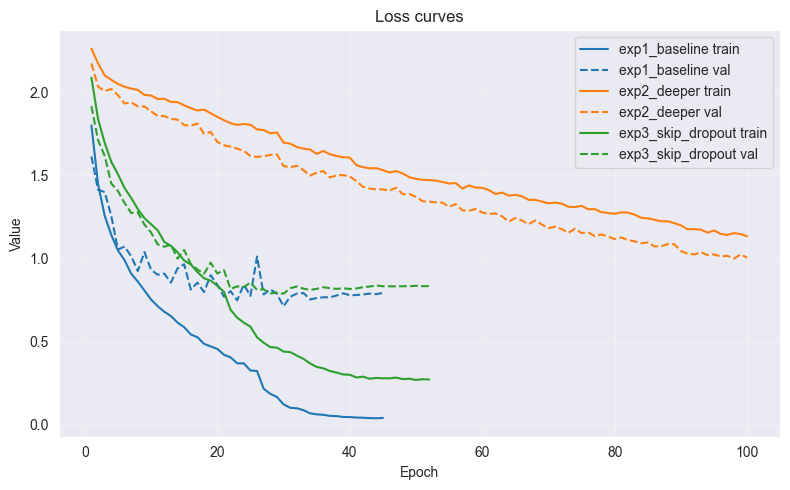

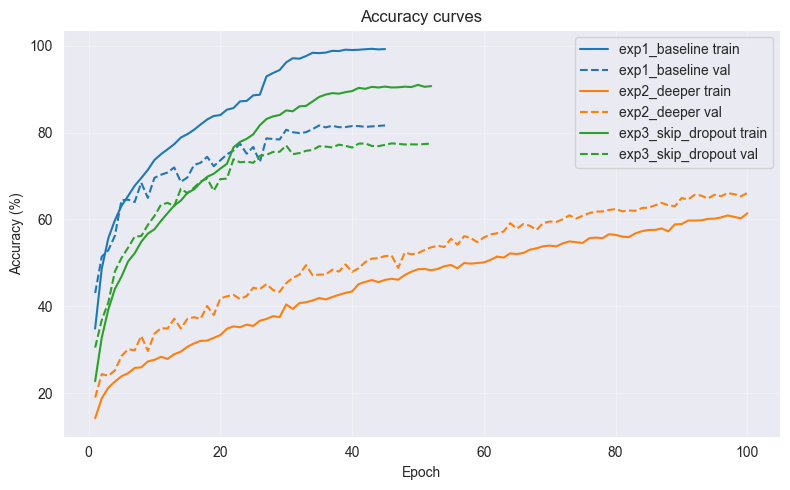

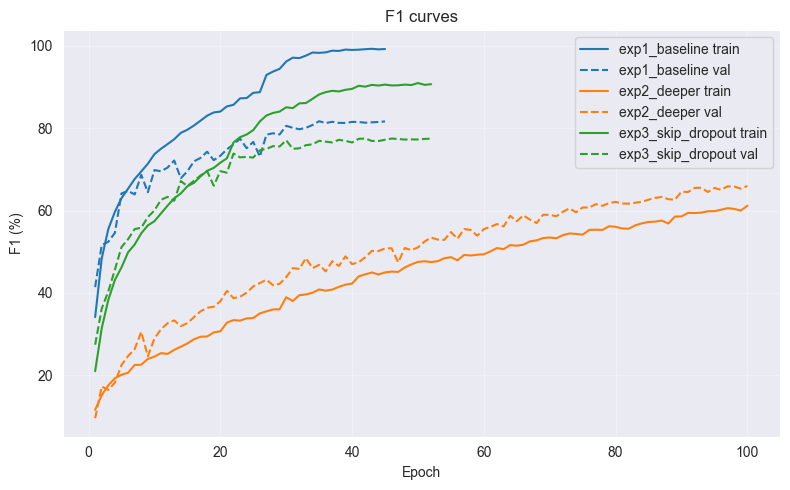

experiment  test_loss   test_acc  test_precision  test_recall  \
0      exp1_baseline   0.717364  82.328869       82.445642    82.316970   
1  exp3_skip_dropout   0.781461  76.413690       76.512336    76.374006   
2        exp2_deeper   1.027252  64.136905       66.054370    64.406624   

     test_f1  best_val_metric  
0  82.354939        81.652400  
1  76.372839        77.521399  
2  63.965167        66.133234

In [28]:
# Plot training history across experiments (solid=train, dashed=val per experiment)
metrics_to_plot = ["loss", "accuracy", "f1"]
color_map = plt.cm.get_cmap("tab10")
exp_names = list(experiment_results.keys())
colors = {name: color_map(i % 10) for i, name in enumerate(exp_names)}

for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    for exp_name, res in experiment_results.items():
        color = colors[exp_name]
        train_curve = [m[metric] for m in res["history"]["train"]]
        val_curve = [m[metric] for m in res["history"]["val"]]
        epochs_range = range(1, len(train_curve) + 1)
        plt.plot(epochs_range, train_curve, label=f"{exp_name} train", color=color, linestyle="-")
        plt.plot(epochs_range, val_curve, label=f"{exp_name} val", color=color, linestyle="--")
    plt.xlabel('Epoch')
    ylabel = 'Value' if metric == 'loss' else f"{metric.capitalize()} (%)"
    plt.ylabel(ylabel)
    plt.title(f"{metric.capitalize()} curves")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Tabular summary of test metrics
rows = []
for exp_name, res in experiment_results.items():
    tm = res["test_metrics"]
    rows.append({
        "experiment": exp_name,
        "test_loss": tm["loss"],
        "test_acc": tm["accuracy"],
        "test_precision": tm["precision"],
        "test_recall": tm["recall"],
        "test_f1": tm["f1"],
        "best_val_metric": res.get("best_val_metric"),
    })
summary_df = pd.DataFrame(rows)
display(summary_df.sort_values(by="test_f1", ascending=False).reset_index(drop=True))


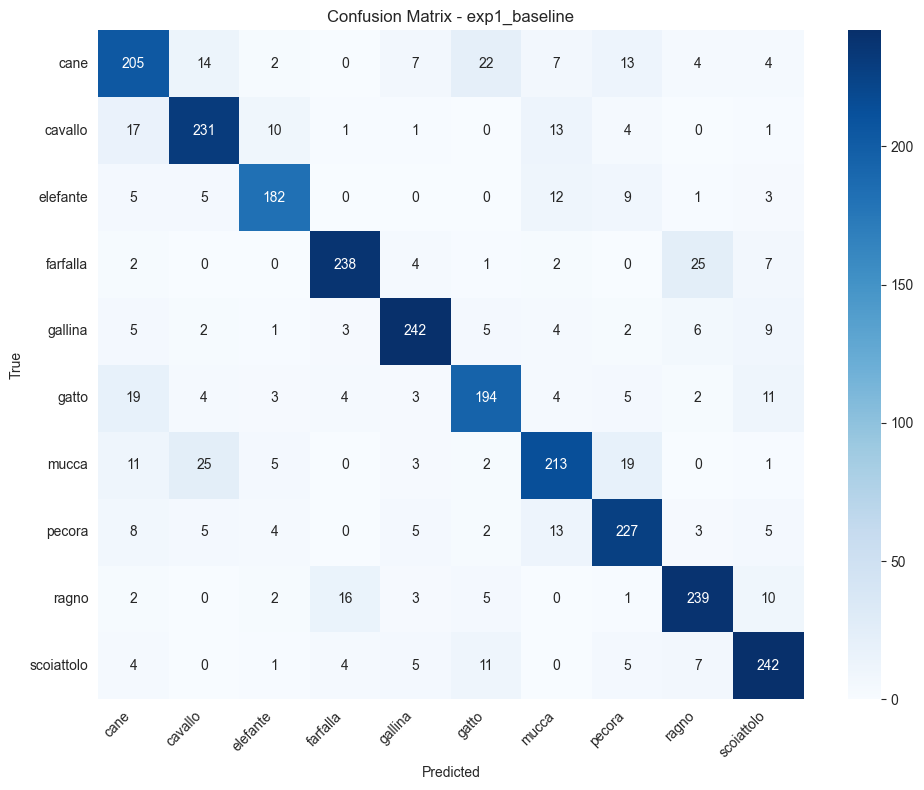

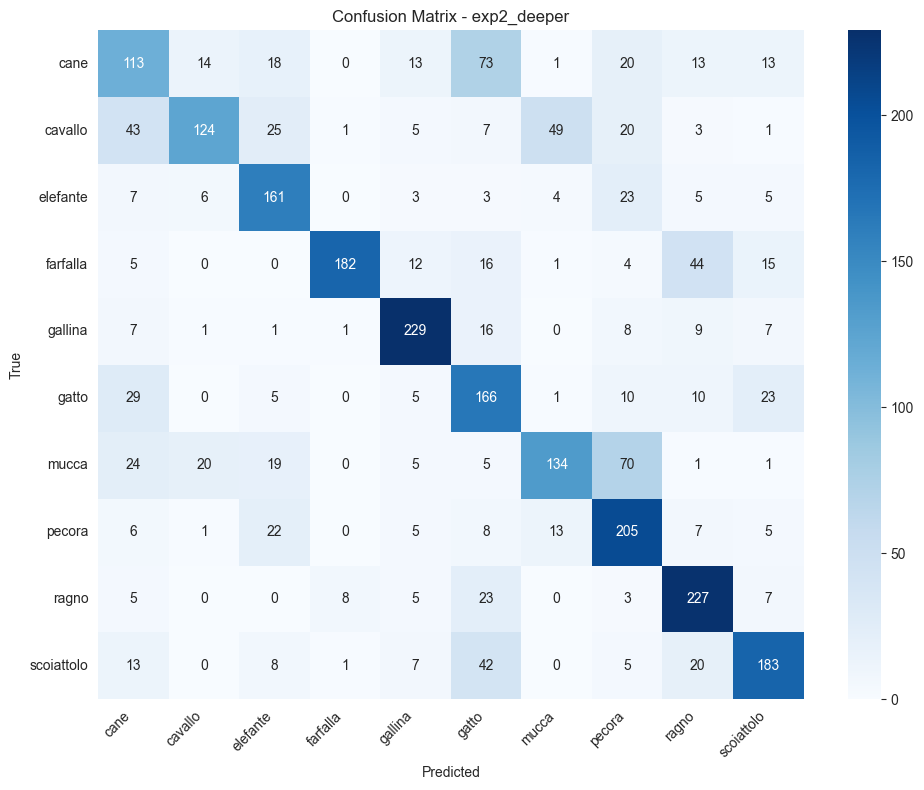

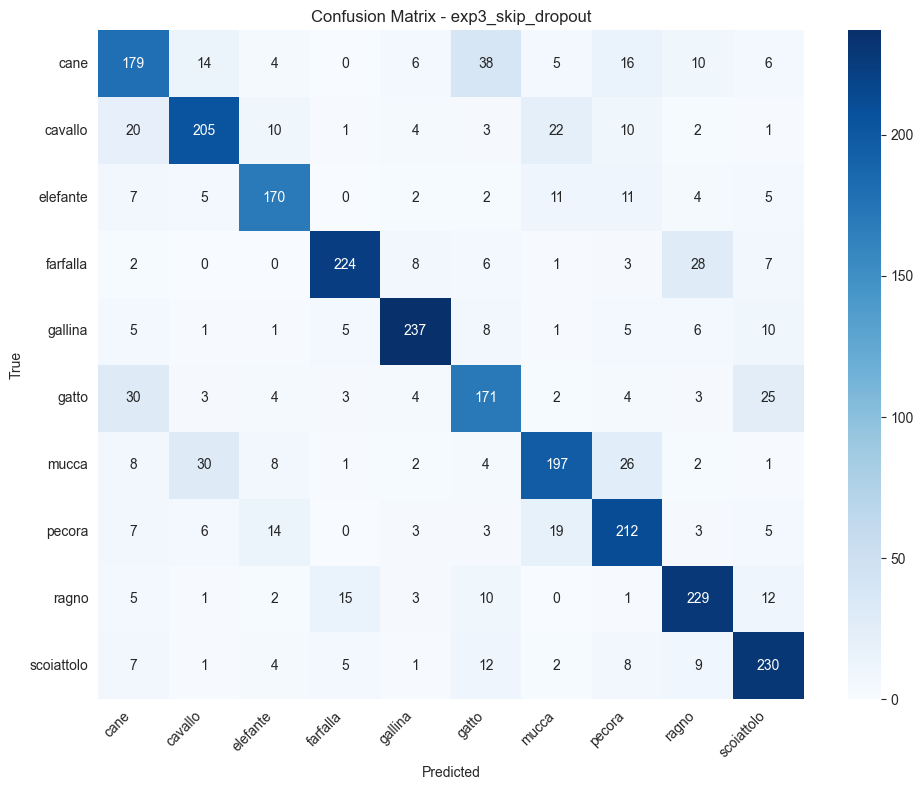

In [29]:
# Confusion matrices per experiment
import seaborn as sns

for exp_name, res in experiment_results.items():
    preds = res["test_preds"]
    labels = res["test_labels"]
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {exp_name}')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

(0.0, 115.0)

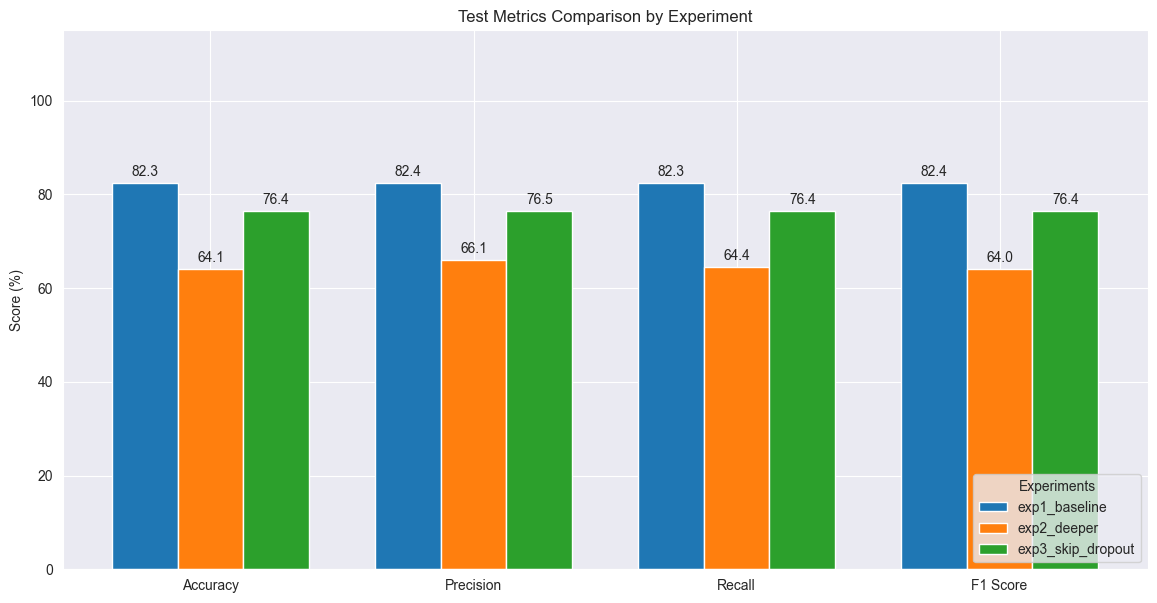

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Extract metrics into a format suitable for plotting
metrics_keys = ["accuracy", "precision", "recall", "f1"]
metrics_labels = ["Accuracy", "Precision", "Recall", "F1 Score"]
exp_names = list(experiment_results.keys())

# Prepare data: { 'exp_name': [acc, prec, rec, f1] }
plot_data = {}
for exp_name in exp_names:
    metrics = experiment_results[exp_name]["test_metrics"]
    plot_data[exp_name] = [metrics[k] for k in metrics_keys]

# 2. Setup plot
x = np.arange(len(metrics_labels))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(14, 7))

# 3. Create bars for each experiment
for exp_name, values in plot_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, values, width, label=exp_name)
    # Add annotations on top of bars
    ax.bar_label(rects, padding=3, fmt='%.1f')
    multiplier += 1

# 4. Formatting
ax.set_ylabel('Score (%)')
ax.set_title('Test Metrics Comparison by Experiment')
# Center x-ticks based on number of experiments
center_offset = width * (len(exp_names) - 1) / 2
ax.set_xticks(x + center_offset)
ax.set_xticklabels(metrics_labels)
ax.legend(loc='lower right', title="Experiments")
ax.set_ylim(0, 115)

## Existing Architecture Experiments

In [30]:
from torchvision.models import (
    resnet18, ResNet18_Weights,
    resnet50, ResNet50_Weights,
    mobilenet_v3_large, MobileNet_V3_Large_Weights,
)

def build_model_with_backbones(exp_cfg):
    model_type = exp_cfg["model"].get("type", "custom_cnn")

    if model_type == "resnet18":
        weights = ResNet18_Weights.DEFAULT
        model = resnet18(weights=weights)
        if exp_cfg["model"].get("freeze_backbone", False):
            for p in model.parameters():
                p.requires_grad = False
        model.fc = nn.Linear(model.fc.in_features, base_data_cfg["num_classes"])
        return model.to(device)

    if model_type == "resnet50":
        weights = ResNet50_Weights.DEFAULT
        model = resnet50(weights=weights)
        if exp_cfg["model"].get("freeze_backbone", False):
            for p in model.parameters():
                p.requires_grad = False
        model.fc = nn.Linear(model.fc.in_features, base_data_cfg["num_classes"])
        return model.to(device)

    if model_type == "mobilenet_v3_large":
        weights = MobileNet_V3_Large_Weights.DEFAULT
        model = mobilenet_v3_large(weights=weights)
        if exp_cfg["model"].get("freeze_backbone", False):
            for p in model.parameters():
                p.requires_grad = False
        in_f = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_f, base_data_cfg["num_classes"])
        return model.to(device)

    # fallback to CustomCNN
    cfg = {"model": exp_cfg["model"], "data": base_data_cfg}
    return CustomCNN(cfg).to(device)

def train_and_evaluate_backbone(exp_name, exp_cfg, use_wandb=True):
    # identical to train_and_evaluate_resnet but calling the new builder
    epochs = exp_cfg["train"]["epochs"]
    lr = exp_cfg["train"]["learning_rate"]
    wd = exp_cfg["train"]["weight_decay"]
    patience = exp_cfg["train"].get("early_stop_patience")
    monitor_metric = exp_cfg["train"].get("monitor_metric", "accuracy")

    model = build_model_with_backbones(exp_cfg)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

    history = {"train": [], "val": []}
    best_metric = float("-inf")
    best_model_path = f"best_model_{exp_name}.pth"
    epochs_no_improve = 0

    run = None
    if use_wandb:
        run = wandb.init(
            project="zneus-animal",
            name=exp_name,
            reinit=True,
            config={
                "epochs": epochs, "learning_rate": lr, "weight_decay": wd,
                "model": exp_cfg["model"], "description": exp_cfg.get("description", ""),
                "monitor_metric": monitor_metric, "early_stop_patience": patience,
            },
        )

    print(f"\n=== Starting {exp_name} ({exp_cfg.get('description','')}) ===")
    for epoch in range(epochs):
        train_metrics = train_epoch(model, train_loader, criterion, optimizer, device)
        val_metrics, _, _ = validate(model, val_loader, criterion, device)
        scheduler.step(val_metrics["loss"])
        history["train"].append(train_metrics)
        history["val"].append(val_metrics)

        metric_value = val_metrics.get(monitor_metric, float("-inf"))
        if metric_value > best_metric:
            best_metric = metric_value
            epochs_no_improve = 0
            torch.save(model.state_dict(), best_model_path)
        else:
            epochs_no_improve += 1

        if run:
            run.log({
                "epoch": epoch + 1,
                "train/loss": train_metrics["loss"],
                "train/accuracy": train_metrics["accuracy"],
                "train/precision": train_metrics["precision"],
                "train/recall": train_metrics["recall"],
                "train/f1": train_metrics["f1"],
                "val/loss": val_metrics["loss"],
                "val/accuracy": val_metrics["accuracy"],
                "val/precision": val_metrics["precision"],
                "val/recall": val_metrics["recall"],
                "val/f1": val_metrics["f1"],
                "val/early_stop_metric": metric_value,
            })

        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"Train Loss: {train_metrics['loss']:.4f} | Train Acc: {train_metrics['accuracy']:.2f}% | "
            f"Val Loss: {val_metrics['loss']:.4f} | Val Acc: {val_metrics['accuracy']:.2f}% | "
            f"Val F1: {val_metrics['f1']:.2f}%"
        )

        if patience is not None and epochs_no_improve >= patience:
            print(f"Early stopping after {epoch+1} epochs.")
            if run:
                run.log({"early_stopped_epoch": epoch + 1})
            break

    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.to(device)
    test_metrics, test_preds, test_labels = validate(model, test_loader, criterion, device)

    if run:
        run.log({
            "test/loss": test_metrics["loss"],
            "test/accuracy": test_metrics["accuracy"],
            "test/precision": test_metrics["precision"],
            "test/recall": test_metrics["recall"],
            "test/f1": test_metrics["f1"],
            "best_val_metric": best_metric,
        })
        try:
            run.log({
                "test/confusion_matrix": wandb.plot.confusion_matrix(
                    preds=test_preds, y_true=test_labels, class_names=class_names
                )
            })
        except Exception:
            pass
        run.finish()

    print(
        f"\n>>> {exp_name} done | Best Val {monitor_metric}: {best_metric:.2f} | "
        f"Test Acc: {test_metrics['accuracy']:.2f}% | Test F1: {test_metrics['f1']:.2f}%"
    )

    return {
        "history": history,
        "best_val_metric": best_metric,
        "test_metrics": test_metrics,
        "test_preds": test_preds,
        "test_labels": test_labels,
        "best_model_path": best_model_path,
    }

# Example experiment configs for the new backbones
backbone_experiments = {
    "exp4_resnet18_transfer": {
        "description": "Transfer learning ResNet18",
        "model": {"type": "resnet18", "freeze_backbone": True},
        "train": {"epochs": 10, "learning_rate": 1e-3, "weight_decay": 1e-4, "early_stop_patience": 5, "monitor_metric": "accuracy"},
    },
    "exp5_resnet50_transfer": {
        "description": "Transfer learning ResNet50",
        "model": {"type": "resnet50", "freeze_backbone": True},
        "train": {"epochs": 10, "learning_rate": 1e-3, "weight_decay": 1e-4, "early_stop_patience": 5, "monitor_metric": "accuracy"},
    },
    "exp6_mobilenet_v3_large": {
        "description": "Transfer learning MobileNetV3-Large",
        "model": {"type": "mobilenet_v3_large", "freeze_backbone": True},
        "train": {"epochs": 10, "learning_rate": 1e-3, "weight_decay": 1e-4, "early_stop_patience": 5, "monitor_metric": "accuracy"},
    },
}

experiment_results_pretrained = {}

# Run and append results
for exp_name, exp_cfg in backbone_experiments.items():
    experiment_results_pretrained[exp_name] = train_and_evaluate_backbone(exp_name, exp_cfg, use_wandb=False)


=== Starting exp4_resnet18_transfer (Transfer learning ResNet18) ===


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [1/10] | Train Loss: 0.5517 | Train Acc: 86.33% | Val Loss: 0.2587 | Val Acc: 93.26% | Val F1: 93.36%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [2/10] | Train Loss: 0.2256 | Train Acc: 93.81% | Val Loss: 0.1967 | Val Acc: 94.42% | Val F1: 94.50%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [3/10] | Train Loss: 0.1798 | Train Acc: 94.89% | Val Loss: 0.1867 | Val Acc: 94.42% | Val F1: 94.52%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [4/10] | Train Loss: 0.1687 | Train Acc: 94.94% | Val Loss: 0.1747 | Val Acc: 94.31% | Val F1: 94.41%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [5/10] | Train Loss: 0.1566 | Train Acc: 95.27% | Val Loss: 0.1656 | Val Acc: 95.01% | Val F1: 95.08%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [6/10] | Train Loss: 0.1489 | Train Acc: 95.38% | Val Loss: 0.1666 | Val Acc: 94.68% | Val F1: 94.75%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [7/10] | Train Loss: 0.1371 | Train Acc: 95.66% | Val Loss: 0.1678 | Val Acc: 94.79% | Val F1: 94.84%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [8/10] | Train Loss: 0.1349 | Train Acc: 95.85% | Val Loss: 0.1714 | Val Acc: 94.42% | Val F1: 94.48%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [9/10] | Train Loss: 0.1221 | Train Acc: 96.18% | Val Loss: 0.1609 | Val Acc: 95.01% | Val F1: 95.07%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [10/10] | Train Loss: 0.1181 | Train Acc: 96.52% | Val Loss: 0.1668 | Val Acc: 95.09% | Val F1: 95.16%


Val:   0%|          | 0/42 [00:00<?, ?it/s]


>>> exp4_resnet18_transfer done | Best Val accuracy: 95.09 | Test Acc: 95.42% | Test F1: 95.46%
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\matej/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:16<00:00, 6.29MB/s]



=== Starting exp5_resnet50_transfer (Transfer learning ResNet50) ===


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [1/10] | Train Loss: 0.5483 | Train Acc: 90.61% | Val Loss: 0.2040 | Val Acc: 96.61% | Val F1: 96.63%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [2/10] | Train Loss: 0.1600 | Train Acc: 96.57% | Val Loss: 0.1365 | Val Acc: 97.13% | Val F1: 97.16%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [3/10] | Train Loss: 0.1125 | Train Acc: 97.44% | Val Loss: 0.1171 | Val Acc: 97.39% | Val F1: 97.41%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [4/10] | Train Loss: 0.0934 | Train Acc: 97.70% | Val Loss: 0.1086 | Val Acc: 97.28% | Val F1: 97.30%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [5/10] | Train Loss: 0.0778 | Train Acc: 98.09% | Val Loss: 0.1008 | Val Acc: 97.54% | Val F1: 97.56%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [6/10] | Train Loss: 0.0722 | Train Acc: 98.24% | Val Loss: 0.1064 | Val Acc: 97.17% | Val F1: 97.20%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [7/10] | Train Loss: 0.0612 | Train Acc: 98.38% | Val Loss: 0.0985 | Val Acc: 97.32% | Val F1: 97.34%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [8/10] | Train Loss: 0.0564 | Train Acc: 98.62% | Val Loss: 0.0949 | Val Acc: 97.80% | Val F1: 97.81%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [9/10] | Train Loss: 0.0508 | Train Acc: 98.78% | Val Loss: 0.0963 | Val Acc: 97.69% | Val F1: 97.70%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [10/10] | Train Loss: 0.0464 | Train Acc: 98.95% | Val Loss: 0.0945 | Val Acc: 97.58% | Val F1: 97.60%


Val:   0%|          | 0/42 [00:00<?, ?it/s]


>>> exp5_resnet50_transfer done | Best Val accuracy: 97.80 | Test Acc: 97.47% | Test F1: 97.52%
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to C:\Users\matej/.cache\torch\hub\checkpoints\mobilenet_v3_large-5c1a4163.pth


100%|██████████| 21.1M/21.1M [00:05<00:00, 4.29MB/s]



=== Starting exp6_mobilenet_v3_large (Transfer learning MobileNetV3-Large) ===


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [1/10] | Train Loss: 0.6474 | Train Acc: 88.05% | Val Loss: 0.2647 | Val Acc: 94.31% | Val F1: 94.40%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [2/10] | Train Loss: 0.2439 | Train Acc: 94.01% | Val Loss: 0.2122 | Val Acc: 94.53% | Val F1: 94.57%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [3/10] | Train Loss: 0.1987 | Train Acc: 94.60% | Val Loss: 0.1926 | Val Acc: 94.72% | Val F1: 94.77%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [4/10] | Train Loss: 0.1735 | Train Acc: 94.93% | Val Loss: 0.1804 | Val Acc: 95.35% | Val F1: 95.39%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [5/10] | Train Loss: 0.1562 | Train Acc: 95.49% | Val Loss: 0.1733 | Val Acc: 95.24% | Val F1: 95.28%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [6/10] | Train Loss: 0.1471 | Train Acc: 95.57% | Val Loss: 0.1694 | Val Acc: 95.42% | Val F1: 95.46%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [7/10] | Train Loss: 0.1371 | Train Acc: 95.89% | Val Loss: 0.1702 | Val Acc: 95.12% | Val F1: 95.16%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [8/10] | Train Loss: 0.1297 | Train Acc: 96.12% | Val Loss: 0.1656 | Val Acc: 95.09% | Val F1: 95.12%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [9/10] | Train Loss: 0.1287 | Train Acc: 96.12% | Val Loss: 0.1633 | Val Acc: 95.42% | Val F1: 95.46%


Train:   0%|          | 0/196 [00:00<?, ?it/s]

Val:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [10/10] | Train Loss: 0.1164 | Train Acc: 96.42% | Val Loss: 0.1615 | Val Acc: 95.31% | Val F1: 95.34%


Val:   0%|          | 0/42 [00:00<?, ?it/s]


>>> exp6_mobilenet_v3_large done | Best Val accuracy: 95.42 | Test Acc: 94.98% | Test F1: 94.99%


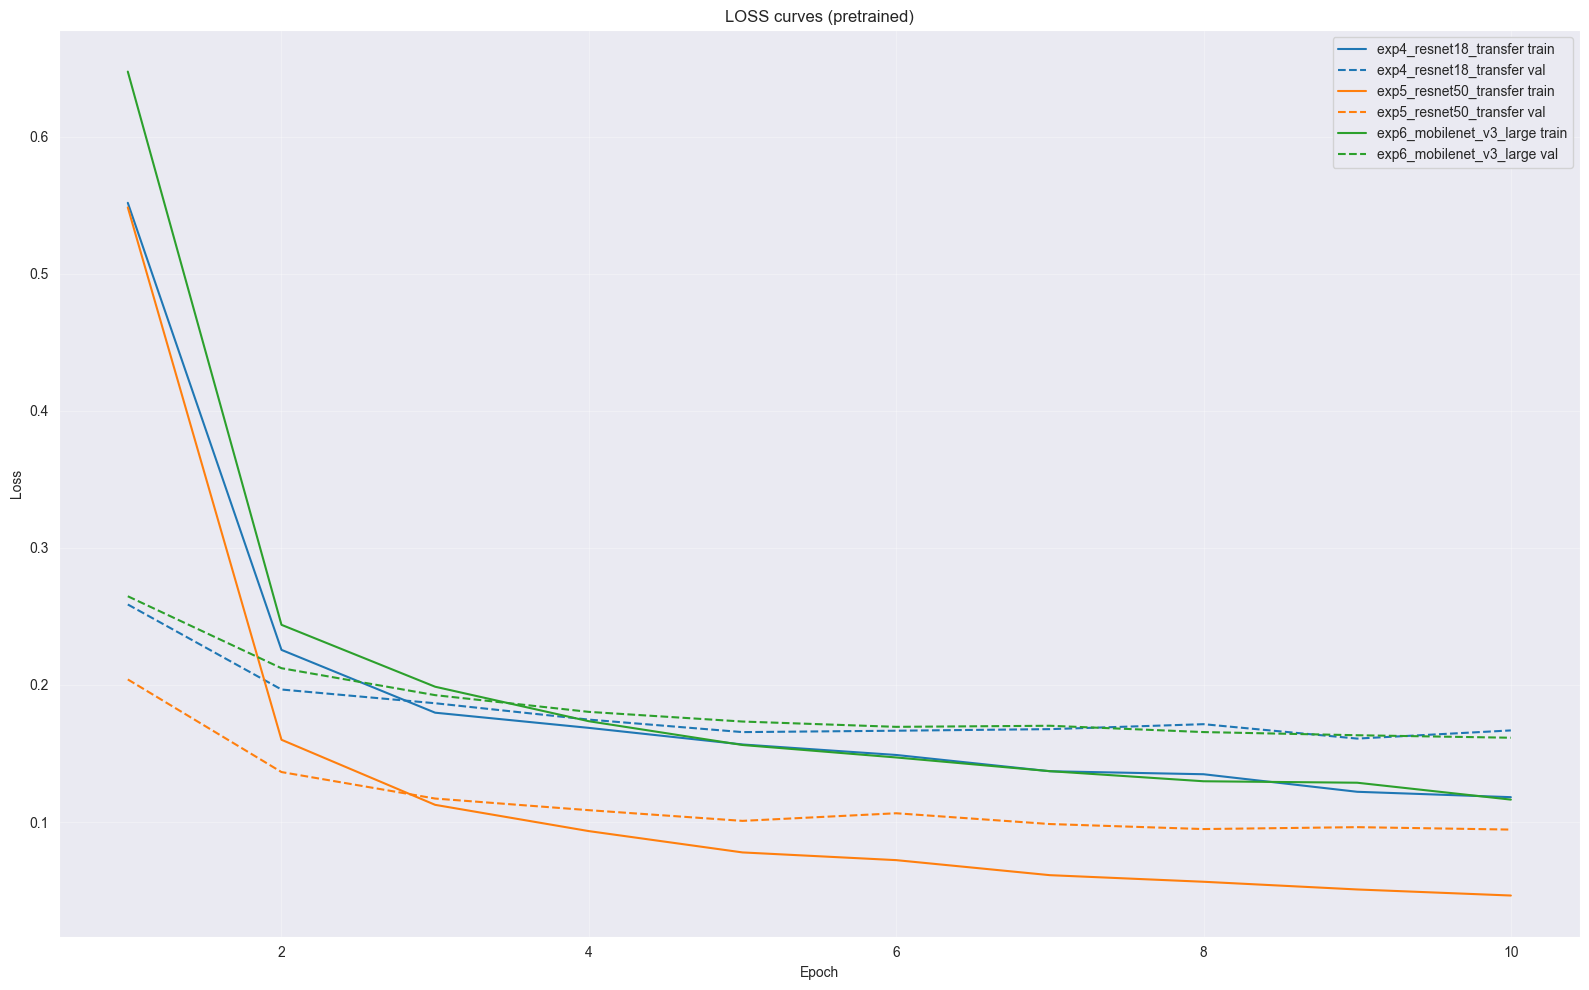

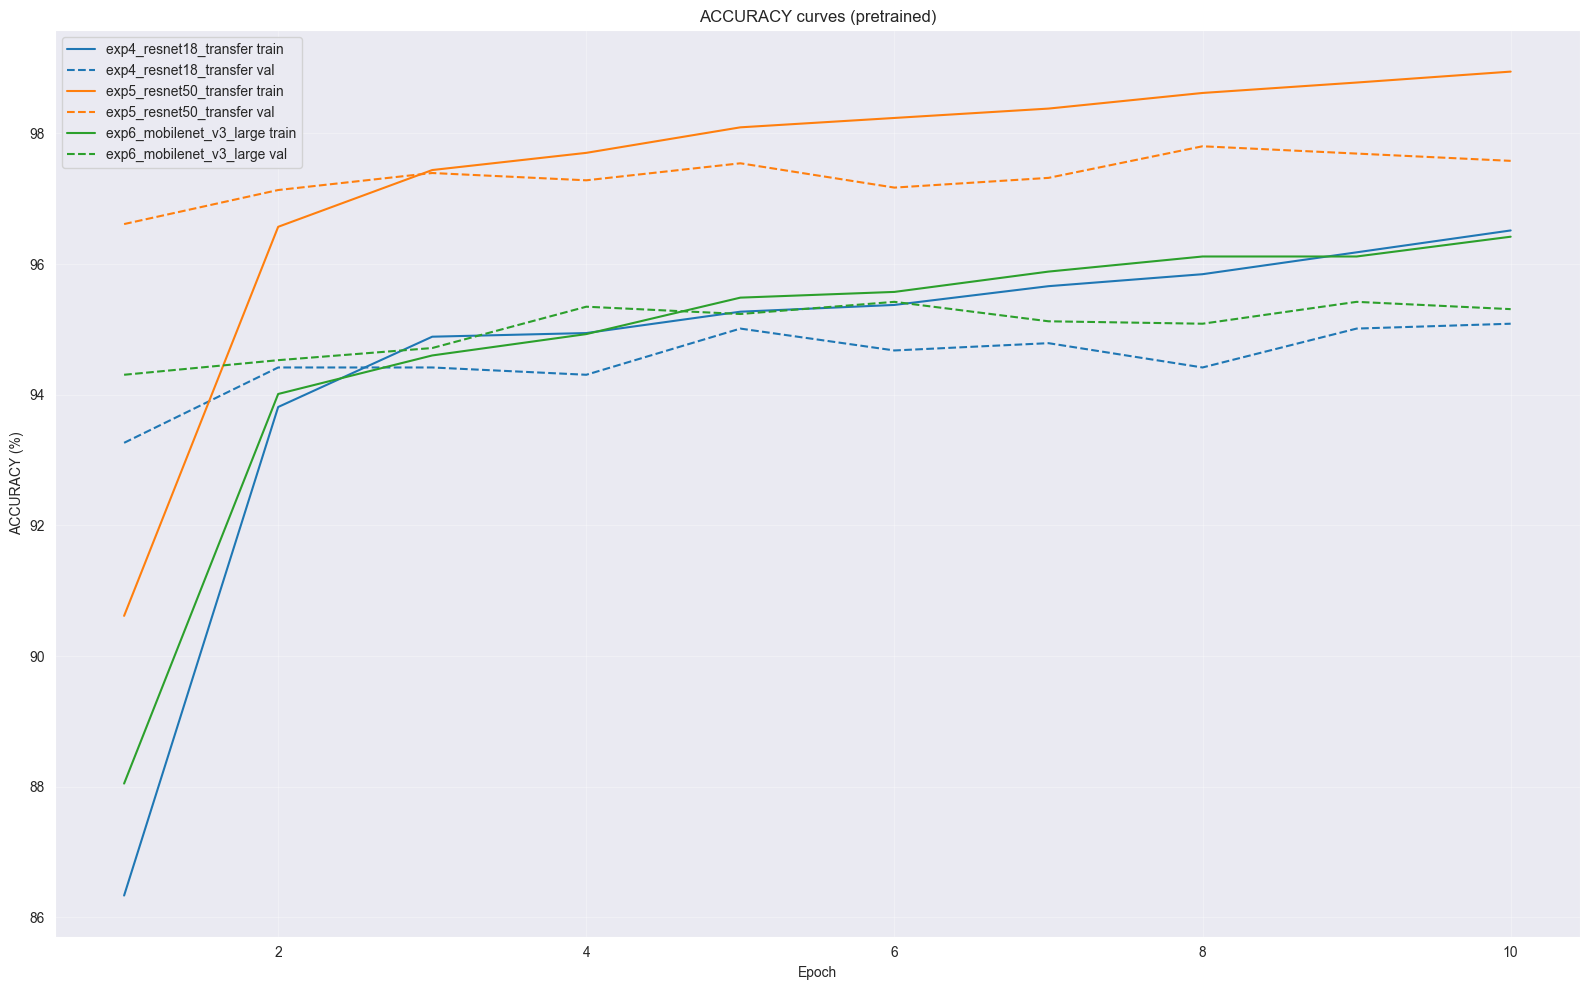

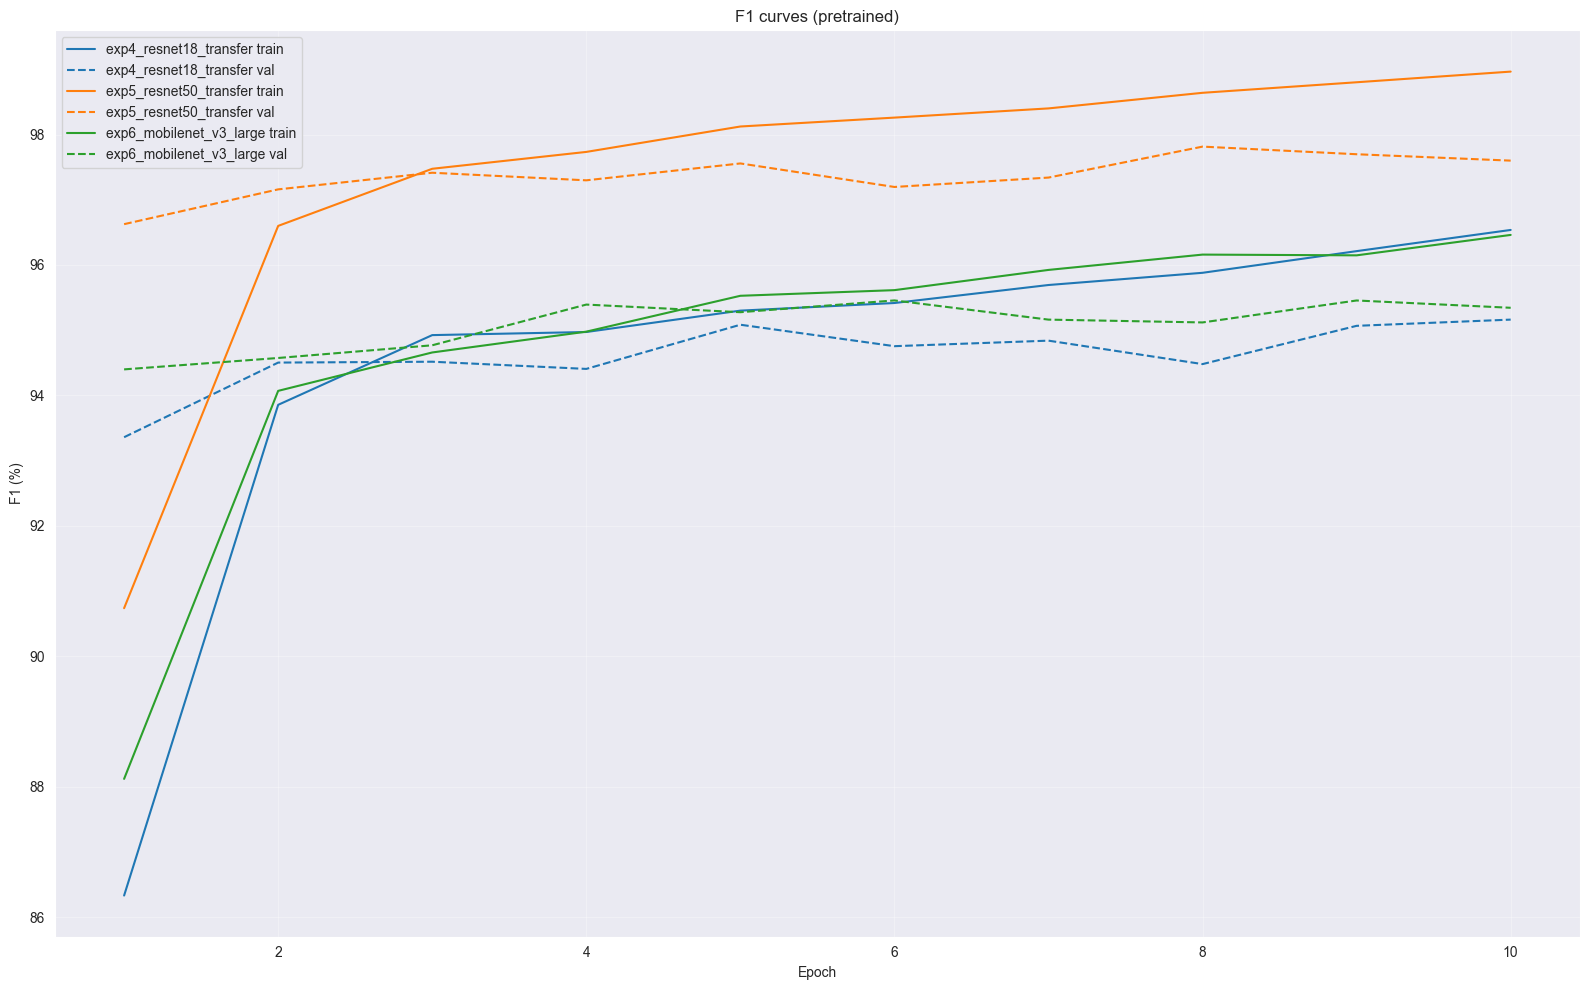

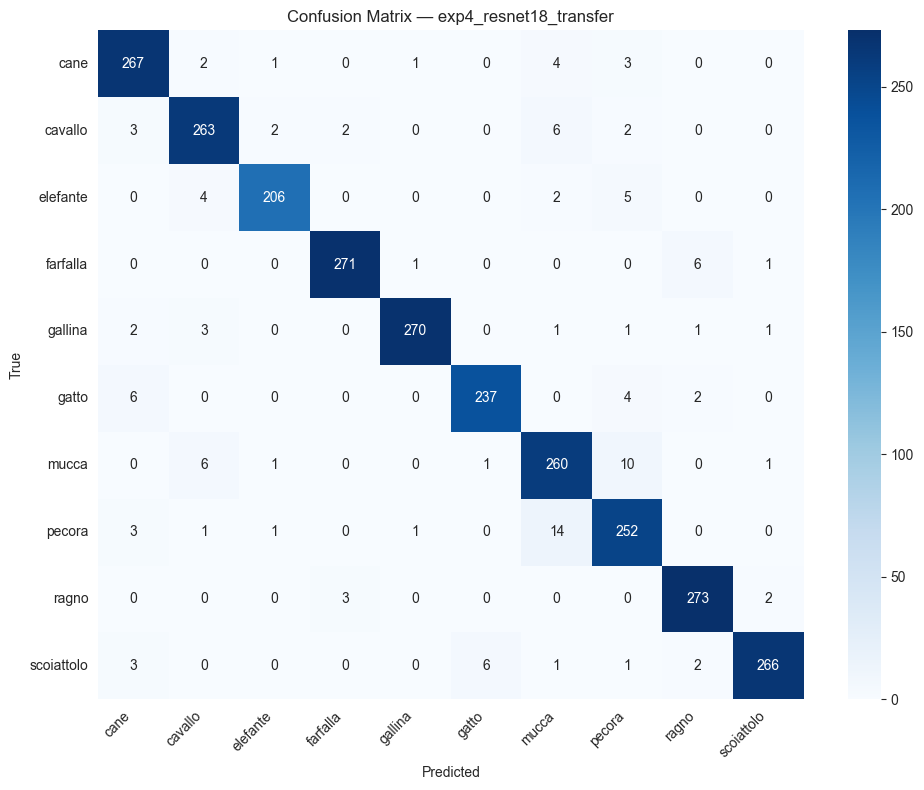

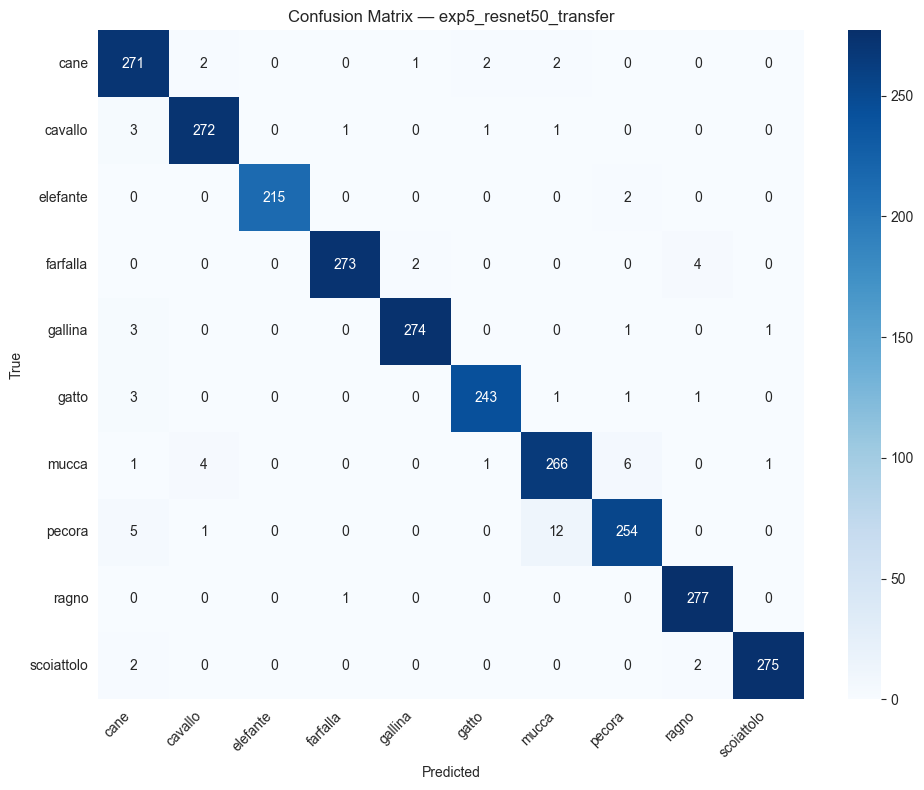

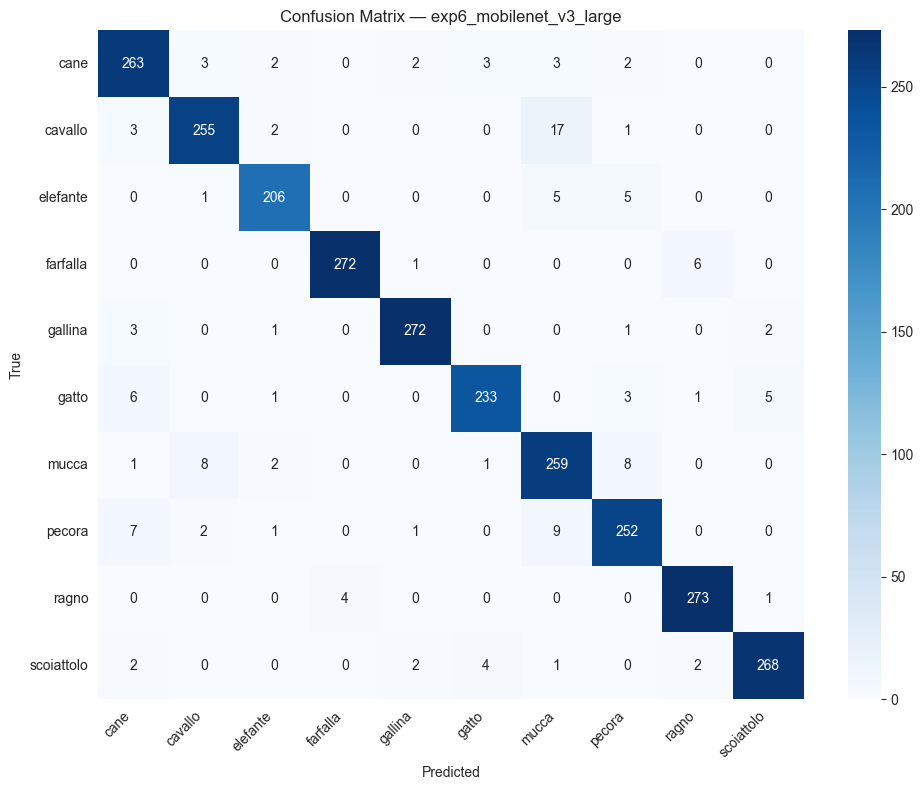

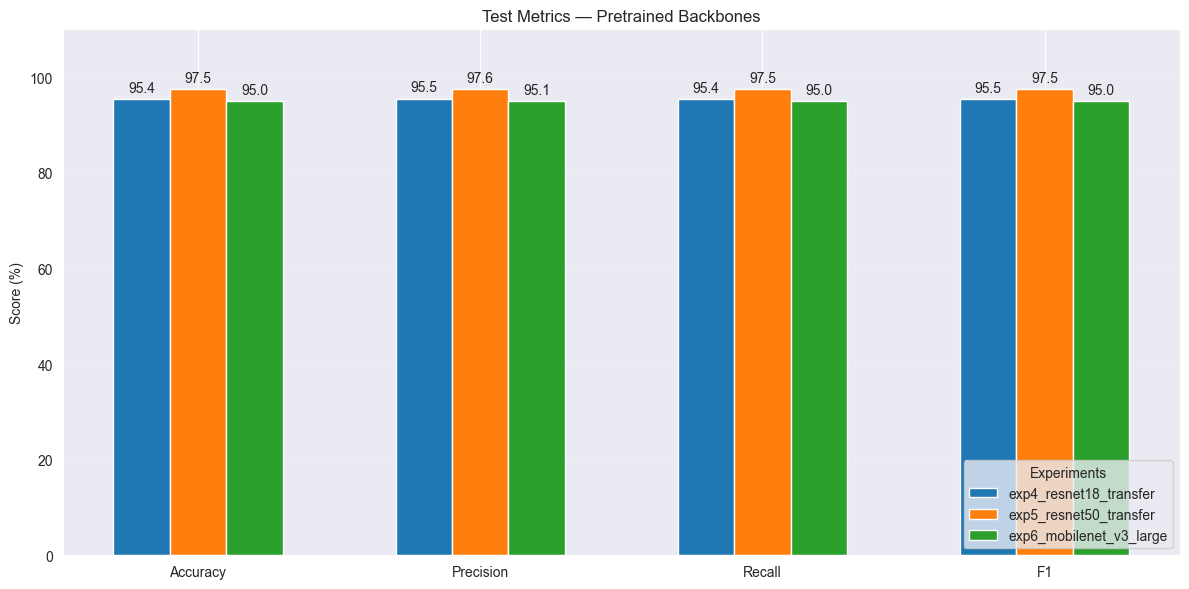

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

def visualize_pretrained_experiments(results_dict):
    if not results_dict:
        print("No pretrained experiment results found.")
        return

    exp_names = list(results_dict.keys())
    color_map = plt.get_cmap("tab10")
    colors = {name: color_map(i % 10) for i, name in enumerate(exp_names)}
    metrics_to_plot = ["loss", "accuracy", "f1"]

    # 1) Training/validation curves for each metric
    for metric in metrics_to_plot:
        plt.figure(figsize=(16, 10))
        for exp_name, res in results_dict.items():
            train_curve = [m[metric] for m in res["history"]["train"]]
            val_curve   = [m[metric] for m in res["history"]["val"]]
            epochs_range = range(1, len(train_curve) + 1)
            plt.plot(epochs_range, train_curve, label=f"{exp_name} train", color=colors[exp_name], linestyle="-")
            plt.plot(epochs_range, val_curve,   label=f"{exp_name} val",   color=colors[exp_name], linestyle="--")
        plt.xlabel("Epoch")
        plt.ylabel("Loss" if metric == "loss" else f"{metric.upper()} (%)")
        plt.title(f"{metric.upper()} curves (pretrained)")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

    # 2) Confusion matrix per experiment
    for exp_name, res in results_dict.items():
        preds = res["test_preds"]
        labels = res["test_labels"]
        cm = confusion_matrix(labels, preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(f"Confusion Matrix — {exp_name}")
        plt.xticks(rotation=45, ha="right")
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    # 3) Barplot of test metrics across experiments
    metrics_keys   = ["accuracy", "precision", "recall", "f1"]
    metrics_labels = ["Accuracy", "Precision", "Recall", "F1"]
    x = np.arange(len(metrics_keys))
    width = 0.2
    multiplier = 0

    fig, ax = plt.subplots(figsize=(12, 6))
    for exp_name in exp_names:
        vals = [results_dict[exp_name]["test_metrics"][k] for k in metrics_keys]
        offset = width * multiplier
        bars = ax.bar(x + offset, vals, width, label=exp_name, color=colors[exp_name])
        ax.bar_label(bars, padding=3, fmt="%.1f")
        multiplier += 1

    center_offset = width * (len(exp_names) - 1) / 2
    ax.set_xticks(x + center_offset)
    ax.set_xticklabels(metrics_labels)
    ax.set_ylabel("Score (%)")
    ax.set_title("Test Metrics — Pretrained Backbones")
    ax.set_ylim(0, 110)
    ax.legend(title="Experiments", loc="lower right")
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

# Run visualization for the pretrained experiments
visualize_pretrained_experiments(experiment_results_pretrained)